In [ ]:
import os, math
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Input, BatchNormalization 
from tensorflow.keras.layers import Conv2D, Flatten, Activation
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
(x_train, _),(x_test, _) = mnist.load_data() 

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
# add one chanel
x_train = x_train.reshape(-1, 28,28,1)

In [ ]:
# normalizacja
x_train = x_train.astype('float32') / 255


In [ ]:
# create genarator

def build_generator(inputs, image_size):
    resize_img = image_size // 4
    kernel_size = 5
    layers_filter = [128, 64, 32, 1]
    # print(resize_img, layers_filter[0])
    x = Dense(resize_img * resize_img * layers_filter[0])(inputs)
    x = Reshape([resize_img, resize_img, layers_filter[0]])(x)

    for i, _filter in enumerate(layers_filter):
        if i <= 1:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)            
        x = Conv2DTranspose(filters=_filter,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)
        


    x = Activation(activation='sigmoid')(x)
    generator = Model(inputs=inputs, outputs=x, name='Generator')
    return generator


In [ ]:
# create discrimintator
def build_discriminator(inputs):
    kernel_size = 5
    layers_filters = [32, 64, 128, 256]
    x = inputs
    for i, _filter in enumerate(layers_filters):
        if i < len(layers_filters) - 1:
            strides = 2
        else:
            strides = 1
        x = LeakyReLU(alpha=.2)(x)
        x = Conv2D(filters=_filter,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    disc = Model(inputs=inputs, outputs=x, name='Discriminator')
    return disc      


In [ ]:
# create model

def build_model(x_train):
    # set hiperams
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4 # .0002
    decay = 6e-8 # .00000006

    image_size = x_train.shape[1]
    # Set discriminator
    
    disc_inputs = Input(shape=x_train.shape[1:], name='Discriminator_inputs')
    discriminator = build_discriminator(inputs=disc_inputs)
    disc_optimizer = RMSprop(learning_rate=lr,
                             decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=disc_optimizer,
                          metrics=['accuracy'])
    discriminator.summary()
    
    # Set generator

    gen_inputs = Input(shape=(latent_size,), name='genarator_inputs')
    generator = build_generator(inputs=gen_inputs, image_size=image_size)
    generator.summary()

    # concatenate two models

    concat_optimizer = RMSprop(learning_rate=lr * .5,
                             decay=decay * .5)
    discriminator.trainable = False
    gan = Model(gen_inputs,
                discriminator(generator(gen_inputs)),
                name='gan_model')
    
    gan.compile(loss='binary_crossentropy',
                        optimizer=concat_optimizer,
                        metrics=['accuracy'])
    gan.summary()

    models = (generator, discriminator, gan)
    params = (batch_size, latent_size, train_steps, 'gan_model')
    train(models, x_train, params)

    


In [ ]:
# Train the Discriminator and Adversarial Networks
def train(models, x_train, params):
    generator, discriminator, gan = models 
    batch_size, latent_size, train_step, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size]) 
    train_size = x_train.shape[0]

    for i in range(train_step):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        x = np.concatenate((real_images, fake_images)) # same size
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        loss, acc = discriminator.train_on_batch(x, y)
        # log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        log = f'{i}: [discriminator loss: {loss}, acc: {acc}]'

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        loss, acc = gan.train_on_batch(noise, y)
        log = "%s [gan loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=True,
                        step=(i + 1),
                        model_name=model_name)



        

In [ ]:
def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    # os.makedirs(model_name, exist_ok=True)
    # filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    # plt.savefig(filename)
    if show:
        
        plt.show()
    else:
        plt.close('all')


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator_inputs (InputL [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 128)       

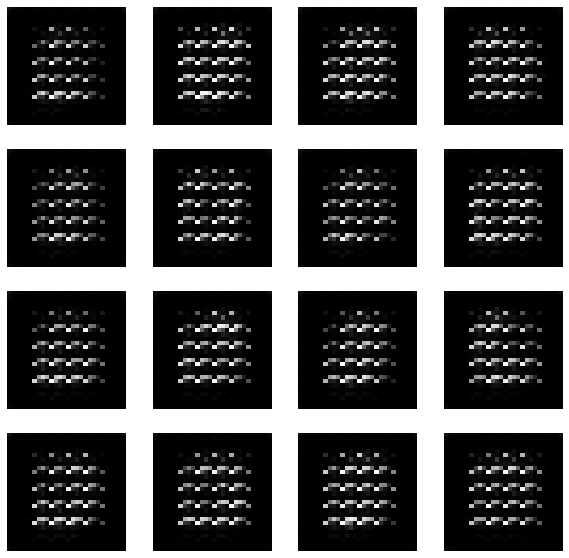

500: [discriminator loss: 0.12813310325145721, acc: 0.9609375] [gan loss: 0.787545, acc: 0.312500]
501: [discriminator loss: 0.2322089672088623, acc: 0.953125] [gan loss: 3.894712, acc: 0.000000]
502: [discriminator loss: 0.2846986949443817, acc: 0.875] [gan loss: 0.132167, acc: 1.000000]
503: [discriminator loss: 0.34729892015457153, acc: 0.7890625] [gan loss: 4.706158, acc: 0.000000]
504: [discriminator loss: 0.17356760799884796, acc: 0.90625] [gan loss: 0.502696, acc: 0.812500]
505: [discriminator loss: 0.24905599653720856, acc: 0.875] [gan loss: 5.003160, acc: 0.000000]
506: [discriminator loss: 0.3571667969226837, acc: 0.8515625] [gan loss: 0.008680, acc: 1.000000]
507: [discriminator loss: 0.6171114444732666, acc: 0.640625] [gan loss: 5.114015, acc: 0.000000]
508: [discriminator loss: 0.4029867649078369, acc: 0.8359375] [gan loss: 0.013812, acc: 1.000000]
509: [discriminator loss: 0.6294698715209961, acc: 0.703125] [gan loss: 4.202666, acc: 0.000000]
510: [discriminator loss: 0.3

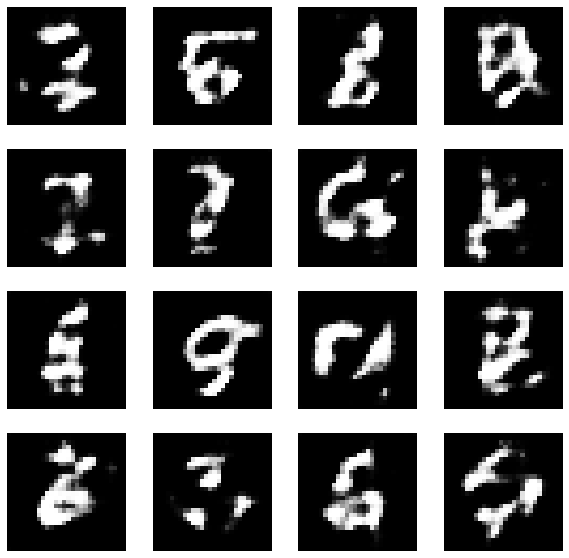

1000: [discriminator loss: 0.5569950938224792, acc: 0.7265625] [gan loss: 1.255069, acc: 0.062500]
1001: [discriminator loss: 0.5740047693252563, acc: 0.7578125] [gan loss: 0.884596, acc: 0.296875]
1002: [discriminator loss: 0.554719090461731, acc: 0.7265625] [gan loss: 1.432257, acc: 0.078125]
1003: [discriminator loss: 0.596013069152832, acc: 0.6953125] [gan loss: 0.728302, acc: 0.515625]
1004: [discriminator loss: 0.5588458180427551, acc: 0.6875] [gan loss: 1.565515, acc: 0.000000]
1005: [discriminator loss: 0.5407993197441101, acc: 0.7109375] [gan loss: 0.772097, acc: 0.453125]
1006: [discriminator loss: 0.6222832202911377, acc: 0.609375] [gan loss: 1.933363, acc: 0.000000]
1007: [discriminator loss: 0.6675875186920166, acc: 0.6328125] [gan loss: 0.559367, acc: 0.781250]
1008: [discriminator loss: 0.5312609672546387, acc: 0.703125] [gan loss: 1.305997, acc: 0.031250]
1009: [discriminator loss: 0.45507577061653137, acc: 0.8046875] [gan loss: 0.897890, acc: 0.375000]
1010: [discrimin

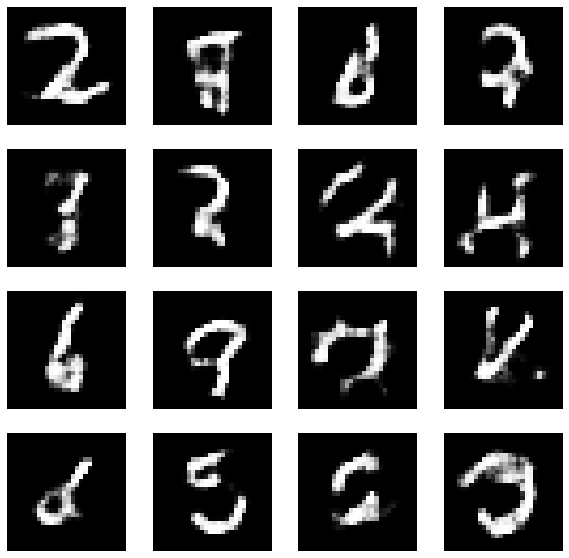

1500: [discriminator loss: 0.38545235991477966, acc: 0.8828125] [gan loss: 1.077579, acc: 0.234375]
1501: [discriminator loss: 0.5401968955993652, acc: 0.703125] [gan loss: 1.254838, acc: 0.218750]
1502: [discriminator loss: 0.5518469214439392, acc: 0.7109375] [gan loss: 0.967969, acc: 0.359375]
1503: [discriminator loss: 0.48823118209838867, acc: 0.765625] [gan loss: 1.460650, acc: 0.125000]
1504: [discriminator loss: 0.5744261145591736, acc: 0.71875] [gan loss: 0.828992, acc: 0.500000]
1505: [discriminator loss: 0.548564076423645, acc: 0.75] [gan loss: 2.156080, acc: 0.093750]
1506: [discriminator loss: 0.6007888913154602, acc: 0.6875] [gan loss: 0.769092, acc: 0.515625]
1507: [discriminator loss: 0.5506770610809326, acc: 0.6640625] [gan loss: 1.789046, acc: 0.078125]
1508: [discriminator loss: 0.6363251805305481, acc: 0.625] [gan loss: 0.731328, acc: 0.546875]
1509: [discriminator loss: 0.6027005910873413, acc: 0.6484375] [gan loss: 1.761737, acc: 0.062500]
1510: [discriminator loss

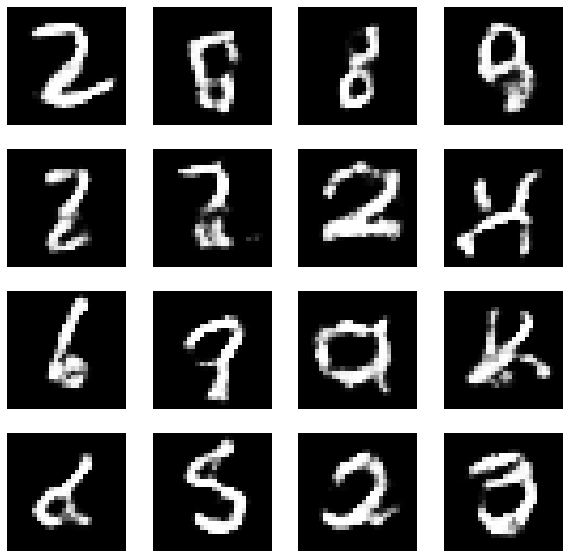

2000: [discriminator loss: 0.5299443602561951, acc: 0.7421875] [gan loss: 0.990289, acc: 0.375000]
2001: [discriminator loss: 0.5437710881233215, acc: 0.7421875] [gan loss: 1.418156, acc: 0.234375]
2002: [discriminator loss: 0.5360553860664368, acc: 0.7890625] [gan loss: 1.022454, acc: 0.328125]
2003: [discriminator loss: 0.43886488676071167, acc: 0.8046875] [gan loss: 1.250899, acc: 0.171875]
2004: [discriminator loss: 0.5438114404678345, acc: 0.71875] [gan loss: 1.678910, acc: 0.031250]
2005: [discriminator loss: 0.5277889966964722, acc: 0.703125] [gan loss: 1.220939, acc: 0.203125]
2006: [discriminator loss: 0.5008678436279297, acc: 0.765625] [gan loss: 1.291165, acc: 0.234375]
2007: [discriminator loss: 0.47463709115982056, acc: 0.78125] [gan loss: 1.112330, acc: 0.281250]
2008: [discriminator loss: 0.46727678179740906, acc: 0.7578125] [gan loss: 1.550707, acc: 0.125000]
2009: [discriminator loss: 0.5587047934532166, acc: 0.6875] [gan loss: 1.054646, acc: 0.312500]
2010: [discrimin

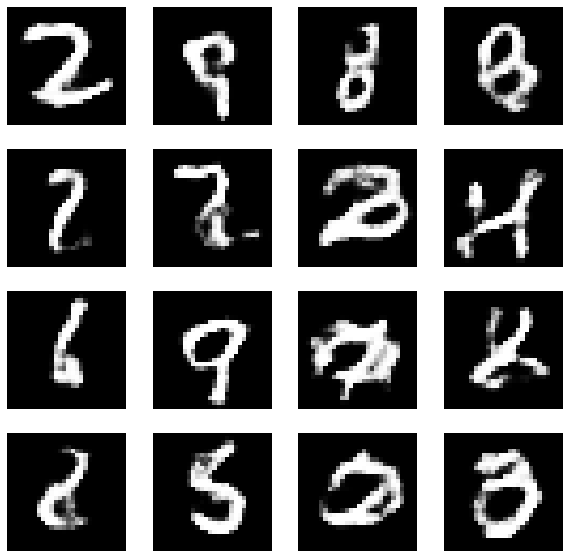

2500: [discriminator loss: 0.47842156887054443, acc: 0.75] [gan loss: 1.660217, acc: 0.062500]
2501: [discriminator loss: 0.4220063090324402, acc: 0.8359375] [gan loss: 1.293787, acc: 0.234375]
2502: [discriminator loss: 0.5258886814117432, acc: 0.7890625] [gan loss: 1.929634, acc: 0.046875]
2503: [discriminator loss: 0.6032477617263794, acc: 0.6484375] [gan loss: 0.902743, acc: 0.468750]
2504: [discriminator loss: 0.5109720230102539, acc: 0.703125] [gan loss: 1.500892, acc: 0.140625]
2505: [discriminator loss: 0.538067102432251, acc: 0.75] [gan loss: 1.053774, acc: 0.312500]
2506: [discriminator loss: 0.487822949886322, acc: 0.765625] [gan loss: 1.152910, acc: 0.218750]
2507: [discriminator loss: 0.5144375562667847, acc: 0.7265625] [gan loss: 2.013974, acc: 0.046875]
2508: [discriminator loss: 0.6144728064537048, acc: 0.640625] [gan loss: 0.787154, acc: 0.484375]
2509: [discriminator loss: 0.49065133929252625, acc: 0.7421875] [gan loss: 1.848697, acc: 0.078125]
2510: [discriminator lo

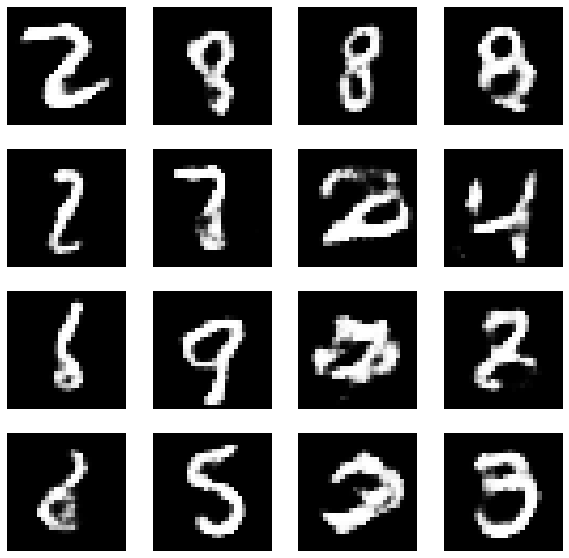

3000: [discriminator loss: 0.5492203235626221, acc: 0.75] [gan loss: 1.491751, acc: 0.125000]
3001: [discriminator loss: 0.486760675907135, acc: 0.7578125] [gan loss: 1.054666, acc: 0.234375]
3002: [discriminator loss: 0.440579891204834, acc: 0.78125] [gan loss: 1.570858, acc: 0.125000]
3003: [discriminator loss: 0.5373542904853821, acc: 0.71875] [gan loss: 0.959030, acc: 0.406250]
3004: [discriminator loss: 0.520572304725647, acc: 0.7109375] [gan loss: 1.452159, acc: 0.125000]
3005: [discriminator loss: 0.4845038950443268, acc: 0.7578125] [gan loss: 1.050326, acc: 0.375000]
3006: [discriminator loss: 0.46173930168151855, acc: 0.7734375] [gan loss: 1.594610, acc: 0.125000]
3007: [discriminator loss: 0.5337984561920166, acc: 0.7578125] [gan loss: 1.091083, acc: 0.343750]
3008: [discriminator loss: 0.5469282865524292, acc: 0.7734375] [gan loss: 2.228837, acc: 0.078125]
3009: [discriminator loss: 0.67767733335495, acc: 0.65625] [gan loss: 0.934086, acc: 0.375000]
3010: [discriminator loss

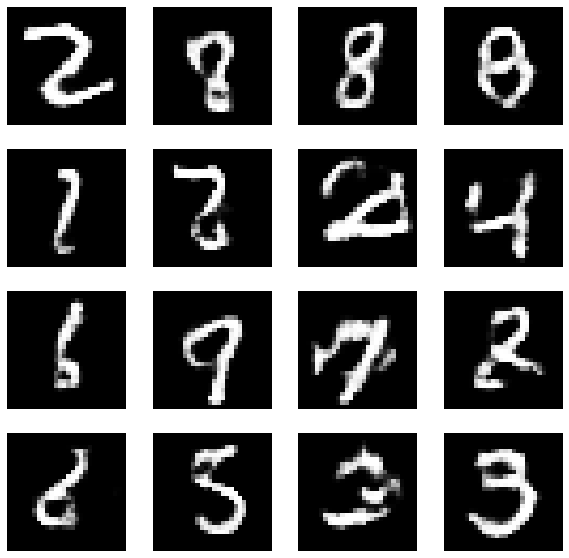

3500: [discriminator loss: 0.5729963183403015, acc: 0.7109375] [gan loss: 1.644584, acc: 0.062500]
3501: [discriminator loss: 0.49446243047714233, acc: 0.75] [gan loss: 1.219735, acc: 0.218750]
3502: [discriminator loss: 0.43322038650512695, acc: 0.84375] [gan loss: 1.276594, acc: 0.218750]
3503: [discriminator loss: 0.43333086371421814, acc: 0.828125] [gan loss: 1.266466, acc: 0.296875]
3504: [discriminator loss: 0.5639600157737732, acc: 0.6875] [gan loss: 1.383198, acc: 0.187500]
3505: [discriminator loss: 0.48039138317108154, acc: 0.7578125] [gan loss: 1.416625, acc: 0.125000]
3506: [discriminator loss: 0.43683570623397827, acc: 0.7734375] [gan loss: 1.447769, acc: 0.140625]
3507: [discriminator loss: 0.562080979347229, acc: 0.671875] [gan loss: 1.238571, acc: 0.281250]
3508: [discriminator loss: 0.6535449028015137, acc: 0.6015625] [gan loss: 1.576599, acc: 0.203125]
3509: [discriminator loss: 0.5120843052864075, acc: 0.703125] [gan loss: 1.092152, acc: 0.281250]
3510: [discriminato

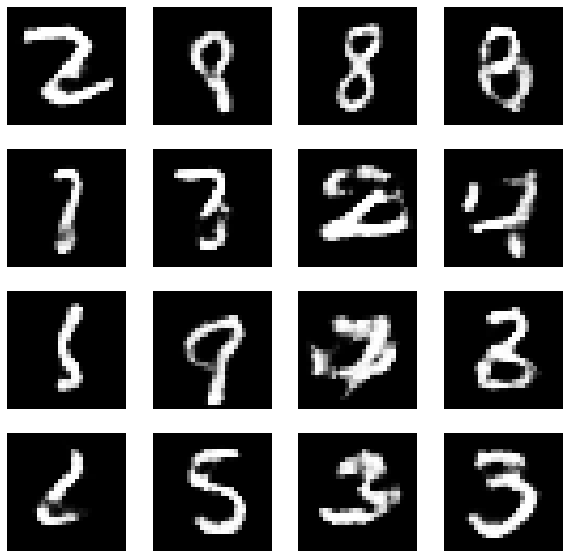

4000: [discriminator loss: 0.4432739317417145, acc: 0.7734375] [gan loss: 1.495089, acc: 0.171875]
4001: [discriminator loss: 0.4197252094745636, acc: 0.8125] [gan loss: 1.398382, acc: 0.156250]
4002: [discriminator loss: 0.4737517833709717, acc: 0.7890625] [gan loss: 1.258461, acc: 0.218750]
4003: [discriminator loss: 0.4662775993347168, acc: 0.765625] [gan loss: 1.163916, acc: 0.281250]
4004: [discriminator loss: 0.44321829080581665, acc: 0.8125] [gan loss: 1.346162, acc: 0.250000]
4005: [discriminator loss: 0.5355894565582275, acc: 0.71875] [gan loss: 1.618811, acc: 0.203125]
4006: [discriminator loss: 0.5095099806785583, acc: 0.75] [gan loss: 1.114229, acc: 0.265625]
4007: [discriminator loss: 0.5188095569610596, acc: 0.7421875] [gan loss: 1.615592, acc: 0.125000]
4008: [discriminator loss: 0.5506240725517273, acc: 0.6953125] [gan loss: 1.078151, acc: 0.296875]
4009: [discriminator loss: 0.5534703731536865, acc: 0.734375] [gan loss: 1.757682, acc: 0.078125]
4010: [discriminator los

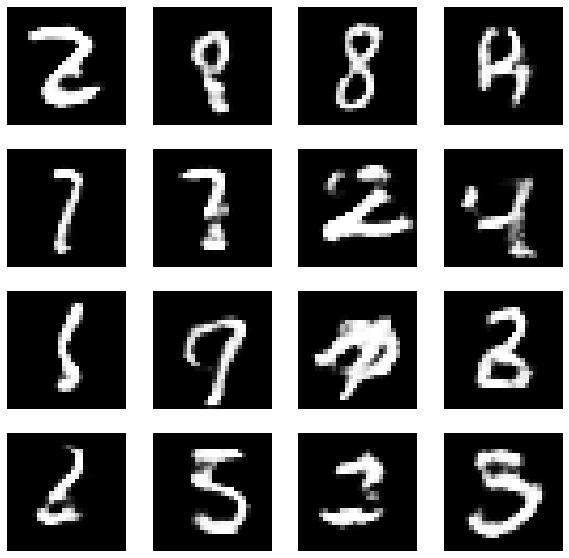

4500: [discriminator loss: 0.5008400678634644, acc: 0.7265625] [gan loss: 1.262674, acc: 0.250000]
4501: [discriminator loss: 0.5497502088546753, acc: 0.7578125] [gan loss: 1.487361, acc: 0.156250]
4502: [discriminator loss: 0.5394084453582764, acc: 0.75] [gan loss: 1.220663, acc: 0.218750]
4503: [discriminator loss: 0.5061094760894775, acc: 0.7578125] [gan loss: 1.691996, acc: 0.062500]
4504: [discriminator loss: 0.6123241782188416, acc: 0.6796875] [gan loss: 1.340783, acc: 0.218750]
4505: [discriminator loss: 0.47477006912231445, acc: 0.796875] [gan loss: 1.067464, acc: 0.265625]
4506: [discriminator loss: 0.5013523697853088, acc: 0.75] [gan loss: 1.860035, acc: 0.046875]
4507: [discriminator loss: 0.5165757536888123, acc: 0.7109375] [gan loss: 0.989879, acc: 0.312500]
4508: [discriminator loss: 0.563974142074585, acc: 0.6875] [gan loss: 1.465494, acc: 0.140625]
4509: [discriminator loss: 0.5306684374809265, acc: 0.71875] [gan loss: 1.150990, acc: 0.250000]
4510: [discriminator loss:

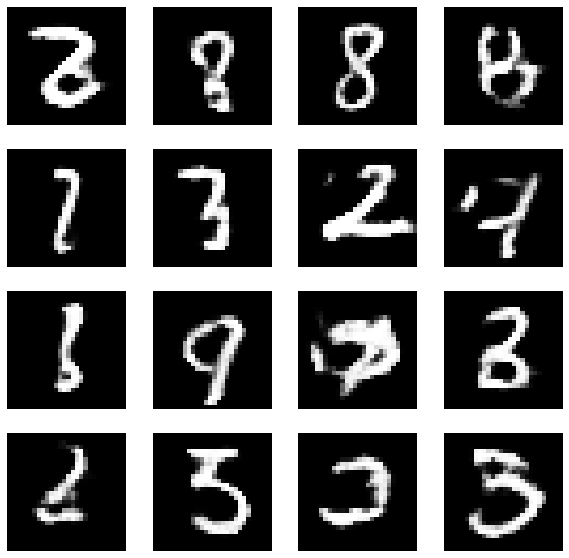

5000: [discriminator loss: 0.4646162986755371, acc: 0.765625] [gan loss: 1.424790, acc: 0.140625]
5001: [discriminator loss: 0.6563044786453247, acc: 0.640625] [gan loss: 0.988849, acc: 0.343750]
5002: [discriminator loss: 0.5259726047515869, acc: 0.75] [gan loss: 1.322177, acc: 0.171875]
5003: [discriminator loss: 0.5793690085411072, acc: 0.7109375] [gan loss: 0.809976, acc: 0.468750]
5004: [discriminator loss: 0.5279993414878845, acc: 0.71875] [gan loss: 1.596851, acc: 0.062500]
5005: [discriminator loss: 0.5599782466888428, acc: 0.7265625] [gan loss: 0.971359, acc: 0.312500]
5006: [discriminator loss: 0.6347977519035339, acc: 0.6796875] [gan loss: 1.586957, acc: 0.093750]
5007: [discriminator loss: 0.5014582872390747, acc: 0.7265625] [gan loss: 1.051308, acc: 0.250000]
5008: [discriminator loss: 0.5869581699371338, acc: 0.703125] [gan loss: 1.365616, acc: 0.125000]
5009: [discriminator loss: 0.5619394183158875, acc: 0.71875] [gan loss: 0.796878, acc: 0.484375]
5010: [discriminator l

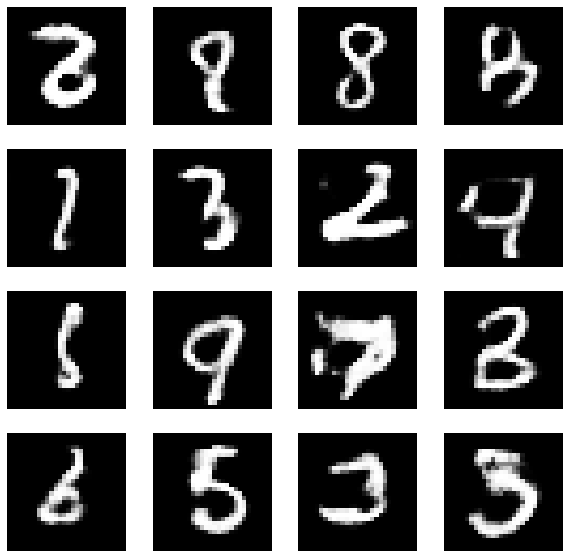

5500: [discriminator loss: 0.4898954927921295, acc: 0.75] [gan loss: 1.299519, acc: 0.203125]
5501: [discriminator loss: 0.5196400284767151, acc: 0.7421875] [gan loss: 1.726779, acc: 0.078125]
5502: [discriminator loss: 0.5325244665145874, acc: 0.703125] [gan loss: 1.034300, acc: 0.359375]
5503: [discriminator loss: 0.6063796877861023, acc: 0.6484375] [gan loss: 1.651934, acc: 0.062500]
5504: [discriminator loss: 0.5736130475997925, acc: 0.734375] [gan loss: 0.896745, acc: 0.468750]
5505: [discriminator loss: 0.6033058762550354, acc: 0.6953125] [gan loss: 1.421461, acc: 0.156250]
5506: [discriminator loss: 0.5397114753723145, acc: 0.7421875] [gan loss: 1.134213, acc: 0.265625]
5507: [discriminator loss: 0.598847508430481, acc: 0.6796875] [gan loss: 1.202771, acc: 0.218750]
5508: [discriminator loss: 0.5352606177330017, acc: 0.7109375] [gan loss: 1.109233, acc: 0.312500]
5509: [discriminator loss: 0.5754437446594238, acc: 0.6796875] [gan loss: 1.171634, acc: 0.312500]
5510: [discriminat

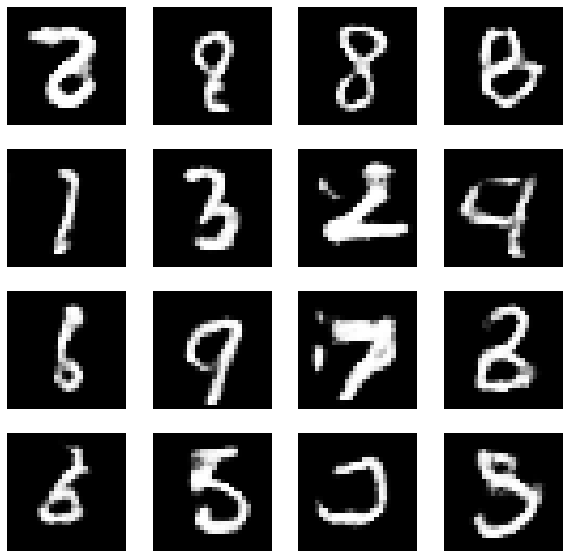

6000: [discriminator loss: 0.6553168296813965, acc: 0.6640625] [gan loss: 0.903332, acc: 0.421875]
6001: [discriminator loss: 0.6160554885864258, acc: 0.640625] [gan loss: 1.815125, acc: 0.093750]
6002: [discriminator loss: 0.5958606600761414, acc: 0.671875] [gan loss: 0.835027, acc: 0.453125]
6003: [discriminator loss: 0.6159252524375916, acc: 0.7265625] [gan loss: 1.183215, acc: 0.281250]
6004: [discriminator loss: 0.4687986373901367, acc: 0.8125] [gan loss: 1.069646, acc: 0.296875]
6005: [discriminator loss: 0.540633499622345, acc: 0.6875] [gan loss: 1.253322, acc: 0.187500]
6006: [discriminator loss: 0.5259585976600647, acc: 0.75] [gan loss: 1.173005, acc: 0.140625]
6007: [discriminator loss: 0.5340332984924316, acc: 0.6953125] [gan loss: 1.150037, acc: 0.203125]
6008: [discriminator loss: 0.48610571026802063, acc: 0.75] [gan loss: 0.874462, acc: 0.406250]
6009: [discriminator loss: 0.5287648439407349, acc: 0.734375] [gan loss: 1.355348, acc: 0.203125]
6010: [discriminator loss: 0.

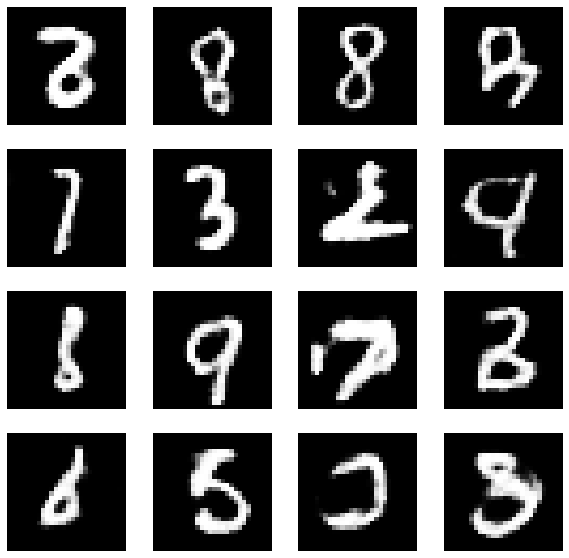

6500: [discriminator loss: 0.5659500360488892, acc: 0.703125] [gan loss: 1.147119, acc: 0.281250]
6501: [discriminator loss: 0.49145931005477905, acc: 0.796875] [gan loss: 1.254320, acc: 0.156250]
6502: [discriminator loss: 0.5370897650718689, acc: 0.734375] [gan loss: 1.187855, acc: 0.343750]
6503: [discriminator loss: 0.5190535187721252, acc: 0.7109375] [gan loss: 1.317355, acc: 0.156250]
6504: [discriminator loss: 0.6090630888938904, acc: 0.65625] [gan loss: 1.214809, acc: 0.234375]
6505: [discriminator loss: 0.5464841723442078, acc: 0.6953125] [gan loss: 0.820953, acc: 0.500000]
6506: [discriminator loss: 0.5267509818077087, acc: 0.78125] [gan loss: 1.418953, acc: 0.171875]
6507: [discriminator loss: 0.5303715467453003, acc: 0.734375] [gan loss: 0.923980, acc: 0.406250]
6508: [discriminator loss: 0.5496060848236084, acc: 0.6953125] [gan loss: 1.250682, acc: 0.218750]
6509: [discriminator loss: 0.565273642539978, acc: 0.6484375] [gan loss: 1.002571, acc: 0.359375]
6510: [discriminat

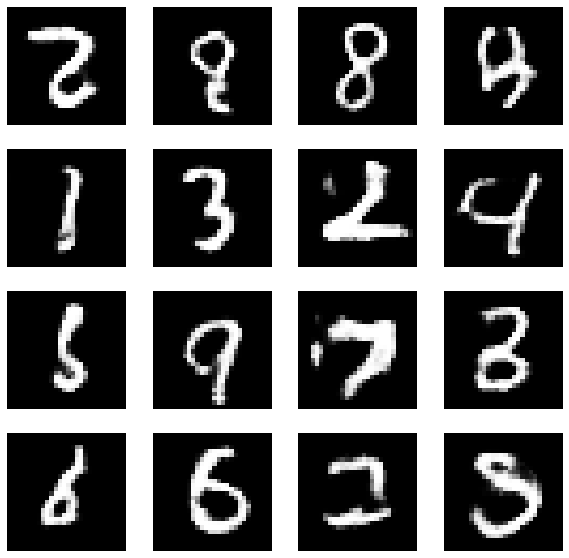

7000: [discriminator loss: 0.5210346579551697, acc: 0.7578125] [gan loss: 1.091006, acc: 0.265625]
7001: [discriminator loss: 0.5613110065460205, acc: 0.6953125] [gan loss: 0.993608, acc: 0.343750]
7002: [discriminator loss: 0.566627562046051, acc: 0.734375] [gan loss: 1.364136, acc: 0.093750]
7003: [discriminator loss: 0.5128709077835083, acc: 0.7265625] [gan loss: 0.826302, acc: 0.500000]
7004: [discriminator loss: 0.5247395634651184, acc: 0.71875] [gan loss: 1.692577, acc: 0.140625]
7005: [discriminator loss: 0.4548594057559967, acc: 0.75] [gan loss: 0.872377, acc: 0.437500]
7006: [discriminator loss: 0.5667665600776672, acc: 0.6796875] [gan loss: 1.403924, acc: 0.140625]
7007: [discriminator loss: 0.5347828269004822, acc: 0.6953125] [gan loss: 0.843690, acc: 0.421875]
7008: [discriminator loss: 0.5557725429534912, acc: 0.71875] [gan loss: 1.397366, acc: 0.265625]
7009: [discriminator loss: 0.5440908670425415, acc: 0.7109375] [gan loss: 0.843294, acc: 0.406250]
7010: [discriminator 

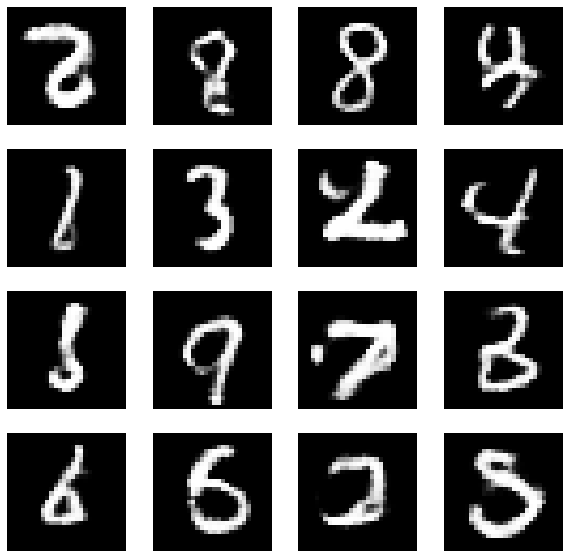

7500: [discriminator loss: 0.520999550819397, acc: 0.765625] [gan loss: 1.241725, acc: 0.187500]
7501: [discriminator loss: 0.5482747554779053, acc: 0.6953125] [gan loss: 0.995453, acc: 0.406250]
7502: [discriminator loss: 0.5295165777206421, acc: 0.6953125] [gan loss: 1.222820, acc: 0.203125]
7503: [discriminator loss: 0.6199389696121216, acc: 0.65625] [gan loss: 1.209332, acc: 0.203125]
7504: [discriminator loss: 0.5785520076751709, acc: 0.71875] [gan loss: 1.281263, acc: 0.187500]
7505: [discriminator loss: 0.5182168483734131, acc: 0.7109375] [gan loss: 1.024807, acc: 0.296875]
7506: [discriminator loss: 0.585391104221344, acc: 0.6953125] [gan loss: 1.146089, acc: 0.250000]
7507: [discriminator loss: 0.5972672700881958, acc: 0.6953125] [gan loss: 0.937516, acc: 0.406250]
7508: [discriminator loss: 0.5218819975852966, acc: 0.71875] [gan loss: 1.186854, acc: 0.265625]
7509: [discriminator loss: 0.5171738862991333, acc: 0.71875] [gan loss: 1.440577, acc: 0.156250]
7510: [discriminator 

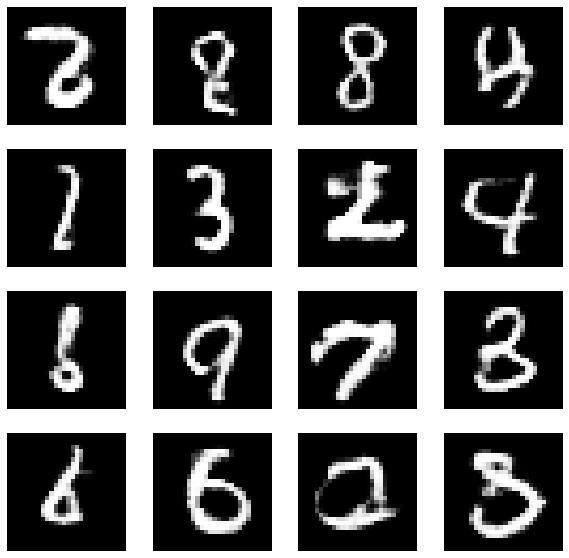

8000: [discriminator loss: 0.5809711813926697, acc: 0.6953125] [gan loss: 1.043436, acc: 0.296875]
8001: [discriminator loss: 0.4549068510532379, acc: 0.8046875] [gan loss: 1.142228, acc: 0.171875]
8002: [discriminator loss: 0.5729522705078125, acc: 0.734375] [gan loss: 1.104503, acc: 0.218750]
8003: [discriminator loss: 0.5029322504997253, acc: 0.75] [gan loss: 1.091134, acc: 0.265625]
8004: [discriminator loss: 0.45932719111442566, acc: 0.78125] [gan loss: 1.437921, acc: 0.171875]
8005: [discriminator loss: 0.640569806098938, acc: 0.640625] [gan loss: 0.954080, acc: 0.406250]
8006: [discriminator loss: 0.5945363640785217, acc: 0.6484375] [gan loss: 1.486689, acc: 0.093750]
8007: [discriminator loss: 0.555628776550293, acc: 0.671875] [gan loss: 1.077857, acc: 0.250000]
8008: [discriminator loss: 0.5692185163497925, acc: 0.6875] [gan loss: 1.304269, acc: 0.093750]
8009: [discriminator loss: 0.5848620533943176, acc: 0.65625] [gan loss: 1.091943, acc: 0.250000]
8010: [discriminator loss:

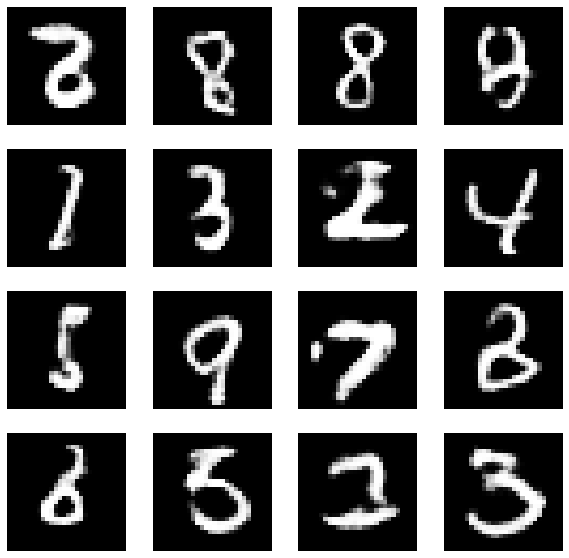

8500: [discriminator loss: 0.6394999623298645, acc: 0.6171875] [gan loss: 1.398035, acc: 0.171875]
8501: [discriminator loss: 0.5308573842048645, acc: 0.703125] [gan loss: 0.970847, acc: 0.375000]
8502: [discriminator loss: 0.5244684219360352, acc: 0.75] [gan loss: 1.411695, acc: 0.093750]
8503: [discriminator loss: 0.5426260828971863, acc: 0.7265625] [gan loss: 0.902513, acc: 0.390625]
8504: [discriminator loss: 0.5203101634979248, acc: 0.7109375] [gan loss: 1.331050, acc: 0.218750]
8505: [discriminator loss: 0.5753781199455261, acc: 0.640625] [gan loss: 1.179759, acc: 0.296875]
8506: [discriminator loss: 0.5314854383468628, acc: 0.7109375] [gan loss: 1.059343, acc: 0.296875]
8507: [discriminator loss: 0.5134931802749634, acc: 0.703125] [gan loss: 1.313377, acc: 0.156250]
8508: [discriminator loss: 0.499098539352417, acc: 0.75] [gan loss: 0.933378, acc: 0.359375]
8509: [discriminator loss: 0.6207977533340454, acc: 0.6640625] [gan loss: 1.483372, acc: 0.125000]
8510: [discriminator los

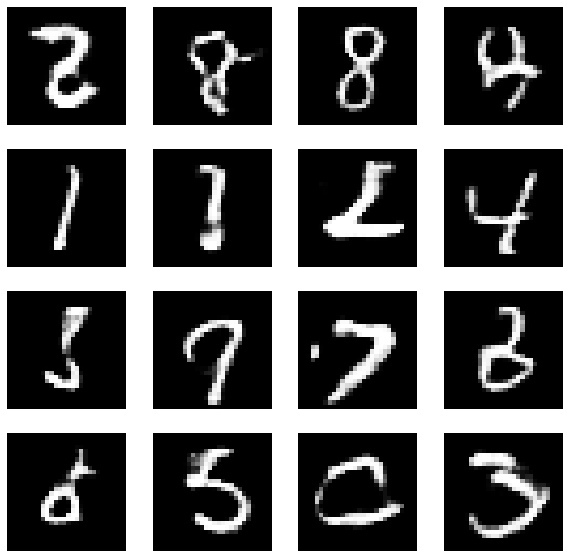

9000: [discriminator loss: 0.5180202126502991, acc: 0.7734375] [gan loss: 1.202838, acc: 0.218750]
9001: [discriminator loss: 0.5266683101654053, acc: 0.7890625] [gan loss: 1.169492, acc: 0.234375]
9002: [discriminator loss: 0.4937109351158142, acc: 0.796875] [gan loss: 1.151517, acc: 0.234375]
9003: [discriminator loss: 0.47848519682884216, acc: 0.7578125] [gan loss: 1.174512, acc: 0.281250]
9004: [discriminator loss: 0.5642808079719543, acc: 0.734375] [gan loss: 1.566979, acc: 0.046875]
9005: [discriminator loss: 0.5935454368591309, acc: 0.703125] [gan loss: 0.826286, acc: 0.468750]
9006: [discriminator loss: 0.5611081719398499, acc: 0.703125] [gan loss: 1.237790, acc: 0.156250]
9007: [discriminator loss: 0.4954949915409088, acc: 0.765625] [gan loss: 0.888701, acc: 0.406250]
9008: [discriminator loss: 0.5124744772911072, acc: 0.71875] [gan loss: 1.686497, acc: 0.109375]
9009: [discriminator loss: 0.49555957317352295, acc: 0.75] [gan loss: 1.033588, acc: 0.328125]
9010: [discriminator

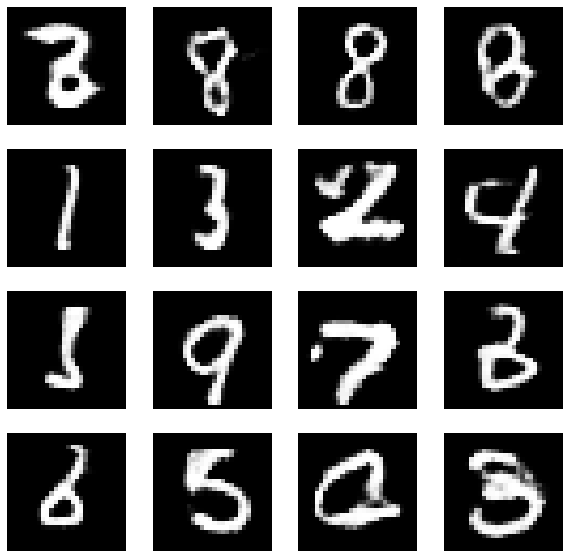

9500: [discriminator loss: 0.5700368285179138, acc: 0.6875] [gan loss: 0.853266, acc: 0.406250]
9501: [discriminator loss: 0.5714799165725708, acc: 0.6796875] [gan loss: 1.615535, acc: 0.093750]
9502: [discriminator loss: 0.5510988235473633, acc: 0.6640625] [gan loss: 1.012312, acc: 0.281250]
9503: [discriminator loss: 0.5967540740966797, acc: 0.703125] [gan loss: 1.369845, acc: 0.140625]
9504: [discriminator loss: 0.6108692288398743, acc: 0.6640625] [gan loss: 1.168499, acc: 0.281250]
9505: [discriminator loss: 0.5586118102073669, acc: 0.6953125] [gan loss: 1.143848, acc: 0.171875]
9506: [discriminator loss: 0.562060534954071, acc: 0.7109375] [gan loss: 1.012153, acc: 0.296875]
9507: [discriminator loss: 0.468395471572876, acc: 0.78125] [gan loss: 1.221728, acc: 0.187500]
9508: [discriminator loss: 0.533417820930481, acc: 0.6640625] [gan loss: 0.853532, acc: 0.437500]
9509: [discriminator loss: 0.5385962724685669, acc: 0.703125] [gan loss: 1.592223, acc: 0.140625]
9510: [discriminator

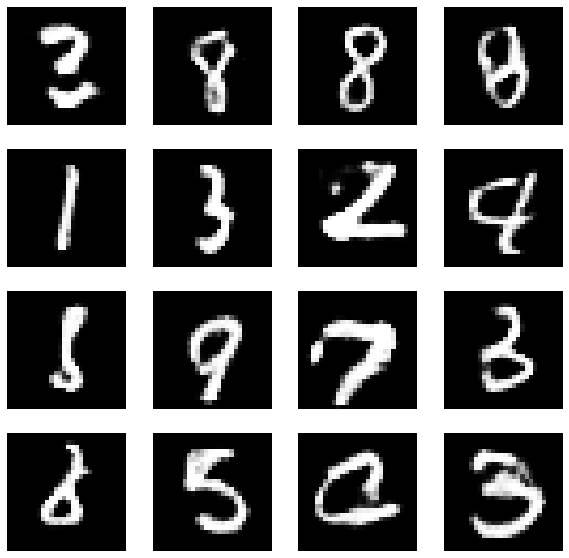

10000: [discriminator loss: 0.5927214622497559, acc: 0.6875] [gan loss: 1.320438, acc: 0.234375]
10001: [discriminator loss: 0.4670437276363373, acc: 0.7578125] [gan loss: 1.212915, acc: 0.265625]
10002: [discriminator loss: 0.612112820148468, acc: 0.65625] [gan loss: 1.351917, acc: 0.171875]
10003: [discriminator loss: 0.5592750310897827, acc: 0.7265625] [gan loss: 0.851529, acc: 0.390625]
10004: [discriminator loss: 0.6433897614479065, acc: 0.65625] [gan loss: 1.586479, acc: 0.093750]
10005: [discriminator loss: 0.5470371842384338, acc: 0.7421875] [gan loss: 0.935043, acc: 0.390625]
10006: [discriminator loss: 0.5606949329376221, acc: 0.7421875] [gan loss: 1.248348, acc: 0.187500]
10007: [discriminator loss: 0.4698617458343506, acc: 0.796875] [gan loss: 1.135981, acc: 0.265625]
10008: [discriminator loss: 0.5811773538589478, acc: 0.7109375] [gan loss: 1.154968, acc: 0.359375]
10009: [discriminator loss: 0.5390909910202026, acc: 0.7421875] [gan loss: 0.990468, acc: 0.359375]
10010: [d

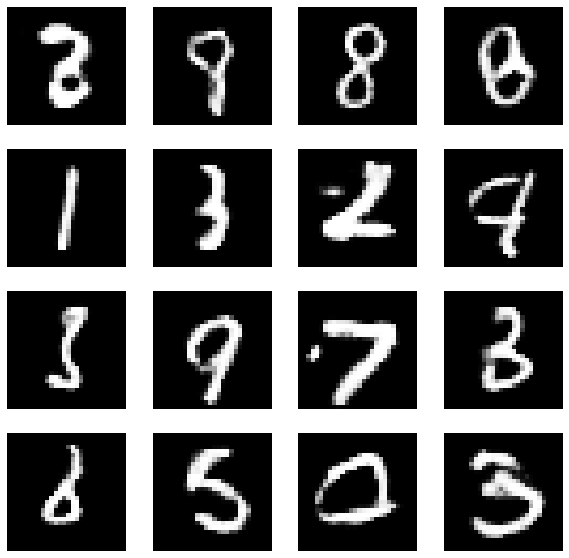

10500: [discriminator loss: 0.5958307385444641, acc: 0.6875] [gan loss: 1.345514, acc: 0.187500]
10501: [discriminator loss: 0.5672413110733032, acc: 0.6875] [gan loss: 0.907655, acc: 0.468750]
10502: [discriminator loss: 0.5801810026168823, acc: 0.6875] [gan loss: 1.320526, acc: 0.187500]
10503: [discriminator loss: 0.50593501329422, acc: 0.7734375] [gan loss: 1.158322, acc: 0.265625]
10504: [discriminator loss: 0.6037943363189697, acc: 0.6796875] [gan loss: 1.199005, acc: 0.156250]
10505: [discriminator loss: 0.5564126968383789, acc: 0.671875] [gan loss: 0.884850, acc: 0.453125]
10506: [discriminator loss: 0.5534490346908569, acc: 0.7421875] [gan loss: 1.383659, acc: 0.171875]
10507: [discriminator loss: 0.5443527102470398, acc: 0.71875] [gan loss: 1.117010, acc: 0.265625]
10508: [discriminator loss: 0.5634558796882629, acc: 0.7265625] [gan loss: 1.093765, acc: 0.218750]
10509: [discriminator loss: 0.5789069533348083, acc: 0.6953125] [gan loss: 1.328448, acc: 0.187500]
10510: [discri

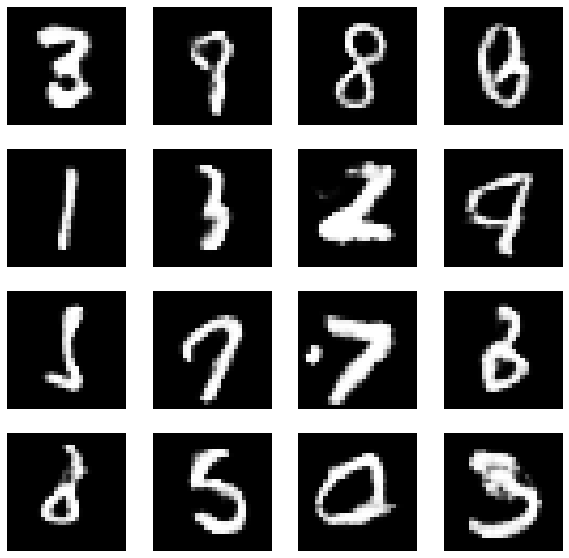

11000: [discriminator loss: 0.5741539001464844, acc: 0.671875] [gan loss: 1.684075, acc: 0.062500]
11001: [discriminator loss: 0.6311132311820984, acc: 0.65625] [gan loss: 0.848918, acc: 0.453125]
11002: [discriminator loss: 0.5715405941009521, acc: 0.75] [gan loss: 1.437828, acc: 0.156250]
11003: [discriminator loss: 0.5078538060188293, acc: 0.734375] [gan loss: 1.341705, acc: 0.187500]
11004: [discriminator loss: 0.5333815217018127, acc: 0.71875] [gan loss: 1.177569, acc: 0.265625]
11005: [discriminator loss: 0.6261871457099915, acc: 0.6640625] [gan loss: 1.117751, acc: 0.296875]
11006: [discriminator loss: 0.5165858268737793, acc: 0.8046875] [gan loss: 1.382679, acc: 0.187500]
11007: [discriminator loss: 0.56905198097229, acc: 0.7109375] [gan loss: 1.082794, acc: 0.250000]
11008: [discriminator loss: 0.5177316665649414, acc: 0.734375] [gan loss: 1.281969, acc: 0.296875]
11009: [discriminator loss: 0.501712441444397, acc: 0.765625] [gan loss: 1.215690, acc: 0.187500]
11010: [discrimi

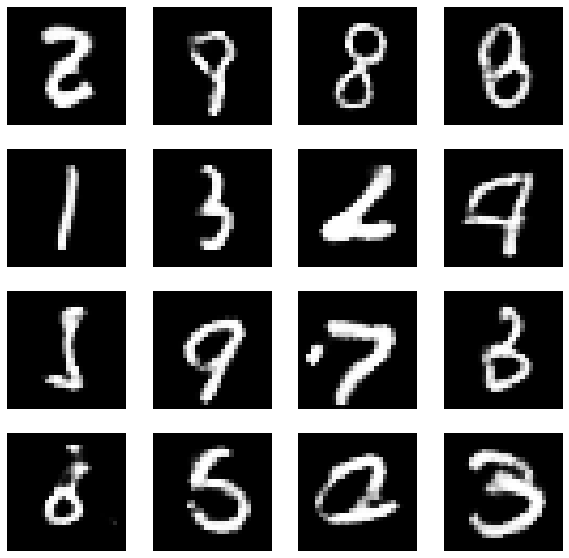

11500: [discriminator loss: 0.5337475538253784, acc: 0.7265625] [gan loss: 0.863869, acc: 0.375000]
11501: [discriminator loss: 0.5349776744842529, acc: 0.7265625] [gan loss: 1.399611, acc: 0.140625]
11502: [discriminator loss: 0.5452742576599121, acc: 0.6953125] [gan loss: 1.055839, acc: 0.281250]
11503: [discriminator loss: 0.5627252459526062, acc: 0.703125] [gan loss: 1.325372, acc: 0.187500]
11504: [discriminator loss: 0.6198090314865112, acc: 0.6796875] [gan loss: 0.899436, acc: 0.328125]
11505: [discriminator loss: 0.6530686616897583, acc: 0.6796875] [gan loss: 1.389314, acc: 0.125000]
11506: [discriminator loss: 0.6175429224967957, acc: 0.671875] [gan loss: 0.851730, acc: 0.484375]
11507: [discriminator loss: 0.6192686557769775, acc: 0.6875] [gan loss: 1.463036, acc: 0.125000]
11508: [discriminator loss: 0.5343591570854187, acc: 0.71875] [gan loss: 0.923440, acc: 0.421875]
11509: [discriminator loss: 0.6359201669692993, acc: 0.65625] [gan loss: 1.349150, acc: 0.218750]
11510: [d

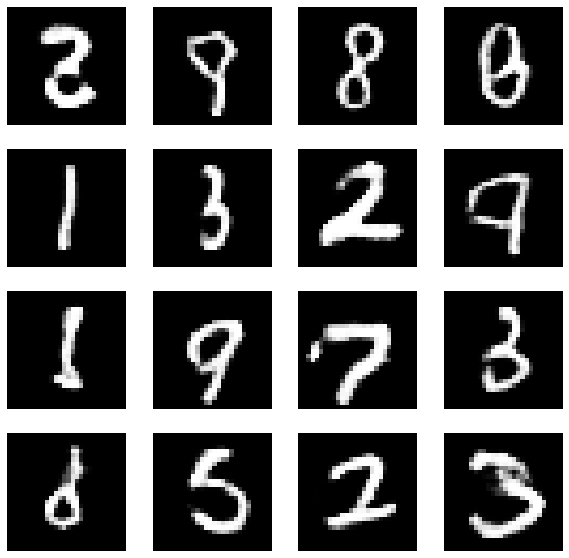

12000: [discriminator loss: 0.574044942855835, acc: 0.7265625] [gan loss: 0.850714, acc: 0.421875]
12001: [discriminator loss: 0.5605206489562988, acc: 0.6875] [gan loss: 1.423871, acc: 0.125000]
12002: [discriminator loss: 0.4543837308883667, acc: 0.828125] [gan loss: 0.995553, acc: 0.328125]
12003: [discriminator loss: 0.45934295654296875, acc: 0.8125] [gan loss: 1.039408, acc: 0.359375]
12004: [discriminator loss: 0.5315709114074707, acc: 0.6875] [gan loss: 1.364298, acc: 0.187500]
12005: [discriminator loss: 0.5675627589225769, acc: 0.703125] [gan loss: 1.476573, acc: 0.187500]
12006: [discriminator loss: 0.5298624038696289, acc: 0.7265625] [gan loss: 1.135261, acc: 0.281250]
12007: [discriminator loss: 0.5186460018157959, acc: 0.75] [gan loss: 0.862663, acc: 0.484375]
12008: [discriminator loss: 0.5740442872047424, acc: 0.703125] [gan loss: 1.529820, acc: 0.109375]
12009: [discriminator loss: 0.5895364880561829, acc: 0.6953125] [gan loss: 0.738158, acc: 0.578125]
12010: [discrimin

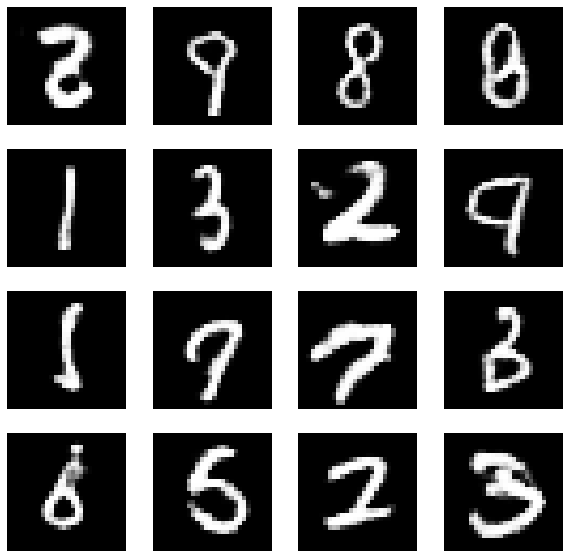

12500: [discriminator loss: 0.5386368632316589, acc: 0.765625] [gan loss: 1.053819, acc: 0.390625]
12501: [discriminator loss: 0.5222931504249573, acc: 0.75] [gan loss: 1.291576, acc: 0.187500]
12502: [discriminator loss: 0.5733085870742798, acc: 0.671875] [gan loss: 1.255080, acc: 0.171875]
12503: [discriminator loss: 0.5514381527900696, acc: 0.671875] [gan loss: 1.216044, acc: 0.265625]
12504: [discriminator loss: 0.53216552734375, acc: 0.71875] [gan loss: 1.330943, acc: 0.187500]
12505: [discriminator loss: 0.5122833251953125, acc: 0.7421875] [gan loss: 1.002477, acc: 0.343750]
12506: [discriminator loss: 0.6495946645736694, acc: 0.6171875] [gan loss: 1.516307, acc: 0.109375]
12507: [discriminator loss: 0.515433132648468, acc: 0.734375] [gan loss: 0.889362, acc: 0.406250]
12508: [discriminator loss: 0.5984628200531006, acc: 0.6640625] [gan loss: 1.132831, acc: 0.343750]
12509: [discriminator loss: 0.555414080619812, acc: 0.6796875] [gan loss: 1.195479, acc: 0.312500]
12510: [discrim

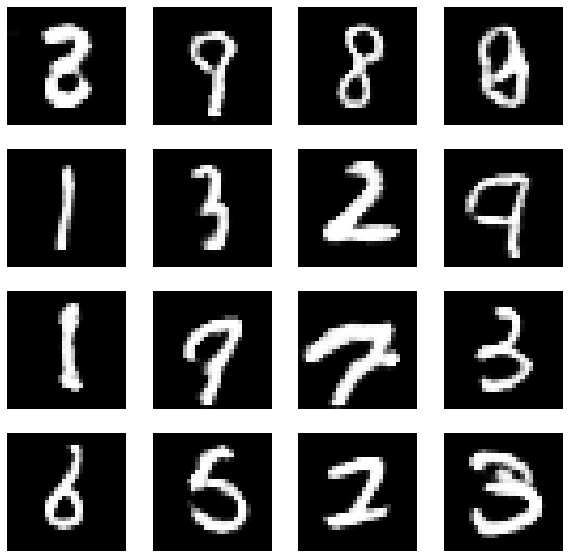

13000: [discriminator loss: 0.5588834881782532, acc: 0.6875] [gan loss: 0.922020, acc: 0.343750]
13001: [discriminator loss: 0.5566688776016235, acc: 0.75] [gan loss: 1.251038, acc: 0.218750]
13002: [discriminator loss: 0.4947616755962372, acc: 0.765625] [gan loss: 1.178905, acc: 0.234375]
13003: [discriminator loss: 0.5277870297431946, acc: 0.7109375] [gan loss: 1.142242, acc: 0.187500]
13004: [discriminator loss: 0.5964735150337219, acc: 0.6796875] [gan loss: 1.066984, acc: 0.296875]
13005: [discriminator loss: 0.5106233358383179, acc: 0.7265625] [gan loss: 1.232817, acc: 0.156250]
13006: [discriminator loss: 0.5354493260383606, acc: 0.7265625] [gan loss: 0.865198, acc: 0.390625]
13007: [discriminator loss: 0.5408859848976135, acc: 0.75] [gan loss: 1.352592, acc: 0.156250]
13008: [discriminator loss: 0.5830161571502686, acc: 0.7265625] [gan loss: 0.652820, acc: 0.671875]
13009: [discriminator loss: 0.5409106612205505, acc: 0.7578125] [gan loss: 1.397921, acc: 0.125000]
13010: [discri

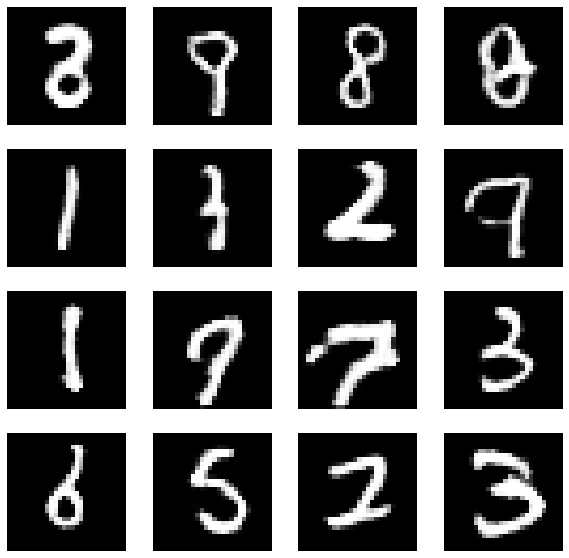

13500: [discriminator loss: 0.5653669834136963, acc: 0.71875] [gan loss: 1.500500, acc: 0.171875]
13501: [discriminator loss: 0.565471351146698, acc: 0.71875] [gan loss: 0.987557, acc: 0.375000]
13502: [discriminator loss: 0.5095801949501038, acc: 0.7421875] [gan loss: 1.325868, acc: 0.125000]
13503: [discriminator loss: 0.5722803473472595, acc: 0.6484375] [gan loss: 0.972407, acc: 0.390625]
13504: [discriminator loss: 0.6028245687484741, acc: 0.7109375] [gan loss: 1.319473, acc: 0.125000]
13505: [discriminator loss: 0.5138692259788513, acc: 0.796875] [gan loss: 1.144486, acc: 0.218750]
13506: [discriminator loss: 0.5606023073196411, acc: 0.6796875] [gan loss: 1.098006, acc: 0.296875]
13507: [discriminator loss: 0.5601791143417358, acc: 0.7421875] [gan loss: 1.081976, acc: 0.265625]
13508: [discriminator loss: 0.5817227363586426, acc: 0.703125] [gan loss: 1.020170, acc: 0.359375]
13509: [discriminator loss: 0.4353257715702057, acc: 0.8203125] [gan loss: 1.135402, acc: 0.265625]
13510: 

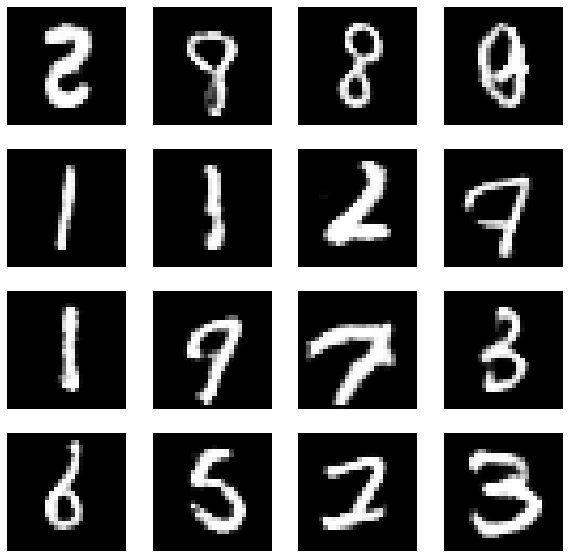

14000: [discriminator loss: 0.5778576731681824, acc: 0.703125] [gan loss: 0.829990, acc: 0.531250]
14001: [discriminator loss: 0.5433075428009033, acc: 0.734375] [gan loss: 1.254923, acc: 0.312500]
14002: [discriminator loss: 0.48126912117004395, acc: 0.7734375] [gan loss: 1.240592, acc: 0.250000]
14003: [discriminator loss: 0.5945274829864502, acc: 0.640625] [gan loss: 1.339227, acc: 0.187500]
14004: [discriminator loss: 0.5739774703979492, acc: 0.6875] [gan loss: 0.828592, acc: 0.406250]
14005: [discriminator loss: 0.4933779835700989, acc: 0.75] [gan loss: 1.525385, acc: 0.093750]
14006: [discriminator loss: 0.5834349989891052, acc: 0.6875] [gan loss: 0.946532, acc: 0.406250]
14007: [discriminator loss: 0.5227188467979431, acc: 0.7421875] [gan loss: 1.114179, acc: 0.218750]
14008: [discriminator loss: 0.5230695009231567, acc: 0.78125] [gan loss: 0.966277, acc: 0.312500]
14009: [discriminator loss: 0.5493603944778442, acc: 0.75] [gan loss: 1.079825, acc: 0.359375]
14010: [discriminato

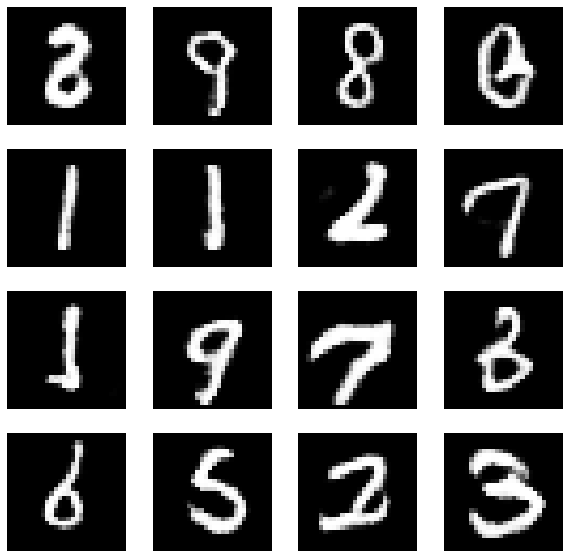

14500: [discriminator loss: 0.4931761622428894, acc: 0.796875] [gan loss: 0.999837, acc: 0.328125]
14501: [discriminator loss: 0.618148148059845, acc: 0.6328125] [gan loss: 1.331982, acc: 0.187500]
14502: [discriminator loss: 0.595660924911499, acc: 0.6328125] [gan loss: 1.114130, acc: 0.312500]
14503: [discriminator loss: 0.6105761528015137, acc: 0.65625] [gan loss: 1.508717, acc: 0.109375]
14504: [discriminator loss: 0.557213544845581, acc: 0.703125] [gan loss: 0.778797, acc: 0.468750]
14505: [discriminator loss: 0.5875997543334961, acc: 0.71875] [gan loss: 1.502266, acc: 0.093750]
14506: [discriminator loss: 0.647314190864563, acc: 0.609375] [gan loss: 0.804079, acc: 0.562500]
14507: [discriminator loss: 0.6009102463722229, acc: 0.65625] [gan loss: 1.532755, acc: 0.109375]
14508: [discriminator loss: 0.5577178597450256, acc: 0.71875] [gan loss: 0.998720, acc: 0.343750]
14509: [discriminator loss: 0.5508274435997009, acc: 0.734375] [gan loss: 1.361419, acc: 0.140625]
14510: [discrimi

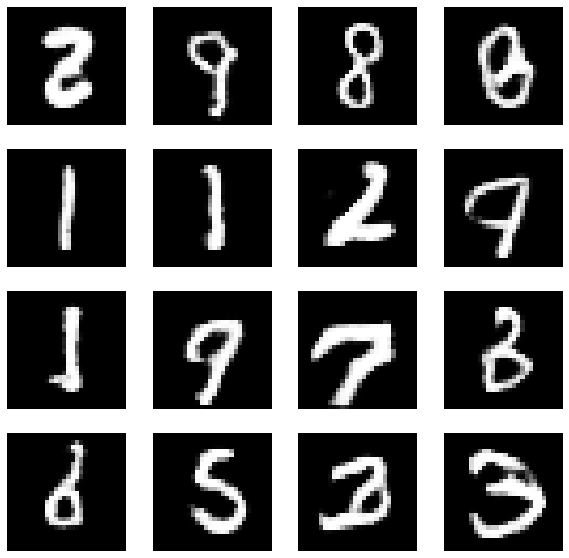

15000: [discriminator loss: 0.5134356021881104, acc: 0.75] [gan loss: 1.246968, acc: 0.203125]
15001: [discriminator loss: 0.5030755400657654, acc: 0.75] [gan loss: 0.982159, acc: 0.375000]
15002: [discriminator loss: 0.5168837904930115, acc: 0.78125] [gan loss: 1.303995, acc: 0.140625]
15003: [discriminator loss: 0.4701650142669678, acc: 0.78125] [gan loss: 1.093378, acc: 0.343750]
15004: [discriminator loss: 0.5452298521995544, acc: 0.7109375] [gan loss: 1.150214, acc: 0.296875]
15005: [discriminator loss: 0.5225883722305298, acc: 0.7734375] [gan loss: 1.081095, acc: 0.281250]
15006: [discriminator loss: 0.6001587510108948, acc: 0.7265625] [gan loss: 1.271886, acc: 0.156250]
15007: [discriminator loss: 0.5612915754318237, acc: 0.6640625] [gan loss: 1.033191, acc: 0.328125]
15008: [discriminator loss: 0.585766077041626, acc: 0.71875] [gan loss: 1.195816, acc: 0.218750]
15009: [discriminator loss: 0.5122554898262024, acc: 0.7578125] [gan loss: 1.618035, acc: 0.046875]
15010: [discrimin

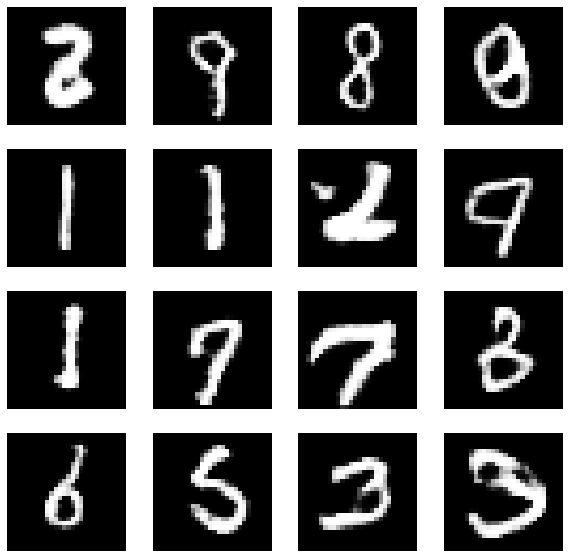

15500: [discriminator loss: 0.5888229012489319, acc: 0.6328125] [gan loss: 2.025426, acc: 0.031250]
15501: [discriminator loss: 0.610925555229187, acc: 0.6484375] [gan loss: 0.859934, acc: 0.468750]
15502: [discriminator loss: 0.5505671501159668, acc: 0.703125] [gan loss: 1.416375, acc: 0.234375]
15503: [discriminator loss: 0.5791133642196655, acc: 0.6640625] [gan loss: 1.050921, acc: 0.328125]
15504: [discriminator loss: 0.5490743517875671, acc: 0.6875] [gan loss: 1.297246, acc: 0.187500]
15505: [discriminator loss: 0.4516720771789551, acc: 0.8203125] [gan loss: 1.051967, acc: 0.296875]
15506: [discriminator loss: 0.5283855199813843, acc: 0.7578125] [gan loss: 0.795967, acc: 0.453125]
15507: [discriminator loss: 0.5154922604560852, acc: 0.734375] [gan loss: 1.619493, acc: 0.171875]
15508: [discriminator loss: 0.6128337383270264, acc: 0.6796875] [gan loss: 0.942223, acc: 0.437500]
15509: [discriminator loss: 0.5365196466445923, acc: 0.703125] [gan loss: 1.370789, acc: 0.281250]
15510: 

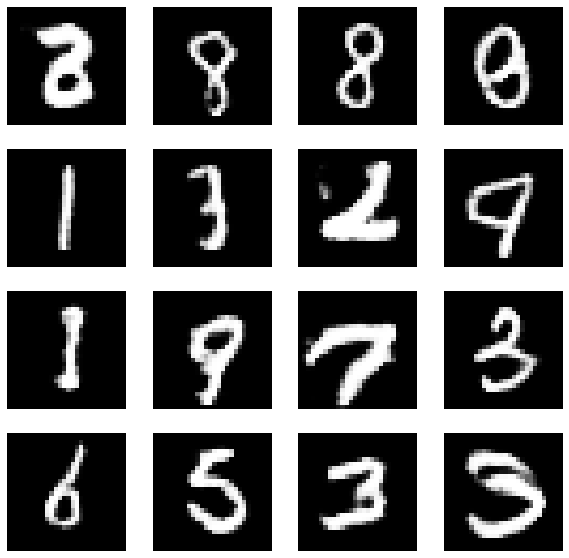

16000: [discriminator loss: 0.5603647828102112, acc: 0.6875] [gan loss: 1.040044, acc: 0.343750]
16001: [discriminator loss: 0.5391790866851807, acc: 0.7109375] [gan loss: 1.083387, acc: 0.281250]
16002: [discriminator loss: 0.5863468647003174, acc: 0.734375] [gan loss: 1.629074, acc: 0.093750]
16003: [discriminator loss: 0.6097601056098938, acc: 0.6640625] [gan loss: 0.711475, acc: 0.593750]
16004: [discriminator loss: 0.6874333620071411, acc: 0.6484375] [gan loss: 1.496127, acc: 0.171875]
16005: [discriminator loss: 0.5911988615989685, acc: 0.65625] [gan loss: 0.886854, acc: 0.406250]
16006: [discriminator loss: 0.6445351839065552, acc: 0.6328125] [gan loss: 1.336806, acc: 0.156250]
16007: [discriminator loss: 0.5687776803970337, acc: 0.6640625] [gan loss: 0.912774, acc: 0.406250]
16008: [discriminator loss: 0.5472620725631714, acc: 0.65625] [gan loss: 1.267130, acc: 0.250000]
16009: [discriminator loss: 0.6211331486701965, acc: 0.6015625] [gan loss: 1.331752, acc: 0.171875]
16010: [

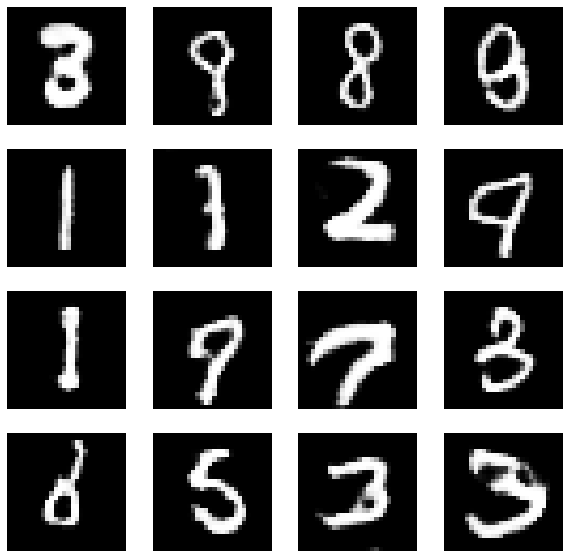

16500: [discriminator loss: 0.516549825668335, acc: 0.765625] [gan loss: 1.397129, acc: 0.140625]
16501: [discriminator loss: 0.5992516279220581, acc: 0.640625] [gan loss: 1.046276, acc: 0.312500]
16502: [discriminator loss: 0.5046764612197876, acc: 0.7421875] [gan loss: 0.951785, acc: 0.359375]
16503: [discriminator loss: 0.5541309118270874, acc: 0.7421875] [gan loss: 1.429136, acc: 0.156250]
16504: [discriminator loss: 0.5450434684753418, acc: 0.7109375] [gan loss: 0.764147, acc: 0.515625]
16505: [discriminator loss: 0.6436582803726196, acc: 0.6640625] [gan loss: 1.308247, acc: 0.187500]
16506: [discriminator loss: 0.5846986174583435, acc: 0.65625] [gan loss: 0.889052, acc: 0.468750]
16507: [discriminator loss: 0.5550540685653687, acc: 0.6875] [gan loss: 1.417634, acc: 0.156250]
16508: [discriminator loss: 0.49328261613845825, acc: 0.7734375] [gan loss: 0.870955, acc: 0.421875]
16509: [discriminator loss: 0.5221748352050781, acc: 0.765625] [gan loss: 1.243085, acc: 0.265625]
16510: [

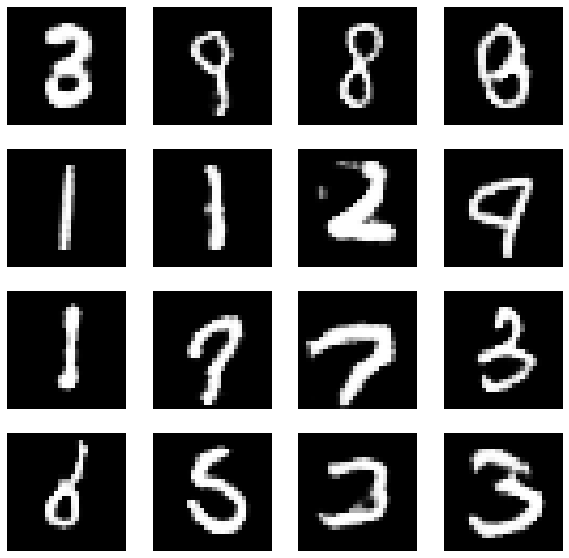

17000: [discriminator loss: 0.5426398515701294, acc: 0.7265625] [gan loss: 1.024075, acc: 0.343750]
17001: [discriminator loss: 0.5198479294776917, acc: 0.75] [gan loss: 1.505730, acc: 0.125000]
17002: [discriminator loss: 0.5582495927810669, acc: 0.75] [gan loss: 1.044310, acc: 0.281250]
17003: [discriminator loss: 0.510902464389801, acc: 0.734375] [gan loss: 1.358416, acc: 0.156250]
17004: [discriminator loss: 0.6090042591094971, acc: 0.640625] [gan loss: 0.951490, acc: 0.359375]
17005: [discriminator loss: 0.5987175107002258, acc: 0.640625] [gan loss: 1.305242, acc: 0.125000]
17006: [discriminator loss: 0.5997322201728821, acc: 0.71875] [gan loss: 1.028780, acc: 0.312500]
17007: [discriminator loss: 0.502747654914856, acc: 0.75] [gan loss: 1.323237, acc: 0.140625]
17008: [discriminator loss: 0.5117896795272827, acc: 0.703125] [gan loss: 0.929439, acc: 0.359375]
17009: [discriminator loss: 0.5759283304214478, acc: 0.75] [gan loss: 1.139644, acc: 0.203125]
17010: [discriminator loss: 

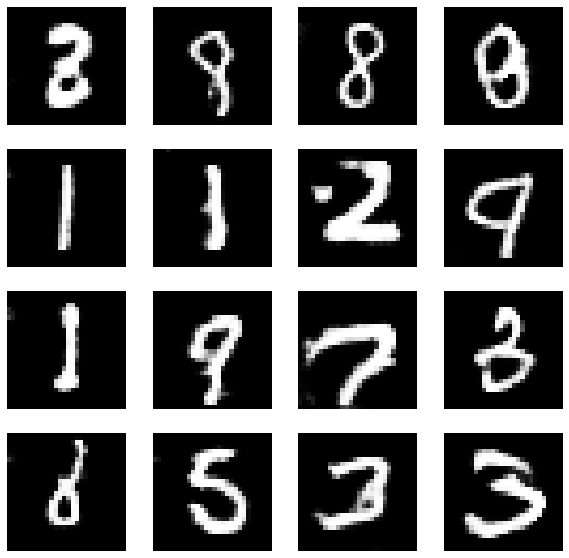

17500: [discriminator loss: 0.5899831056594849, acc: 0.7265625] [gan loss: 1.269817, acc: 0.218750]
17501: [discriminator loss: 0.5474344491958618, acc: 0.6875] [gan loss: 0.934221, acc: 0.500000]
17502: [discriminator loss: 0.5321571230888367, acc: 0.71875] [gan loss: 1.378021, acc: 0.187500]
17503: [discriminator loss: 0.6196137070655823, acc: 0.65625] [gan loss: 0.678419, acc: 0.609375]
17504: [discriminator loss: 0.6075290441513062, acc: 0.6953125] [gan loss: 1.405967, acc: 0.140625]
17505: [discriminator loss: 0.5828054547309875, acc: 0.6328125] [gan loss: 1.069041, acc: 0.359375]
17506: [discriminator loss: 0.5647911429405212, acc: 0.6796875] [gan loss: 1.278166, acc: 0.187500]
17507: [discriminator loss: 0.5410017967224121, acc: 0.671875] [gan loss: 1.300696, acc: 0.156250]
17508: [discriminator loss: 0.5633019208908081, acc: 0.6796875] [gan loss: 1.016160, acc: 0.281250]
17509: [discriminator loss: 0.5323760509490967, acc: 0.7421875] [gan loss: 1.543626, acc: 0.140625]
17510: [

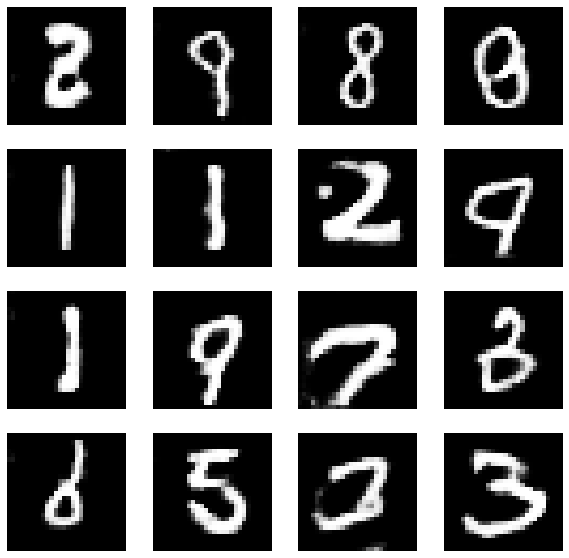

18000: [discriminator loss: 0.4982038736343384, acc: 0.75] [gan loss: 1.160539, acc: 0.234375]
18001: [discriminator loss: 0.5253676176071167, acc: 0.7578125] [gan loss: 1.145509, acc: 0.265625]
18002: [discriminator loss: 0.5488553047180176, acc: 0.7265625] [gan loss: 0.874542, acc: 0.500000]
18003: [discriminator loss: 0.4714878499507904, acc: 0.8046875] [gan loss: 1.488782, acc: 0.156250]
18004: [discriminator loss: 0.6034302711486816, acc: 0.6953125] [gan loss: 0.944396, acc: 0.375000]
18005: [discriminator loss: 0.582703709602356, acc: 0.6953125] [gan loss: 1.488511, acc: 0.109375]
18006: [discriminator loss: 0.530392587184906, acc: 0.7265625] [gan loss: 0.874587, acc: 0.484375]
18007: [discriminator loss: 0.5871070623397827, acc: 0.71875] [gan loss: 1.882200, acc: 0.046875]
18008: [discriminator loss: 0.6133173108100891, acc: 0.65625] [gan loss: 0.667298, acc: 0.562500]
18009: [discriminator loss: 0.6087614297866821, acc: 0.6875] [gan loss: 1.800505, acc: 0.031250]
18010: [discri

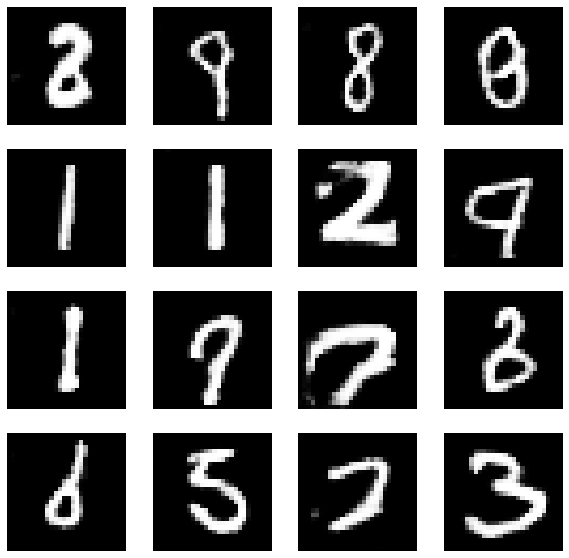

18500: [discriminator loss: 0.5944566130638123, acc: 0.6640625] [gan loss: 1.514619, acc: 0.109375]
18501: [discriminator loss: 0.6393528580665588, acc: 0.6328125] [gan loss: 0.881652, acc: 0.343750]
18502: [discriminator loss: 0.5427801609039307, acc: 0.7109375] [gan loss: 1.331314, acc: 0.140625]
18503: [discriminator loss: 0.5374665856361389, acc: 0.734375] [gan loss: 1.163920, acc: 0.156250]
18504: [discriminator loss: 0.49810469150543213, acc: 0.7578125] [gan loss: 1.144868, acc: 0.265625]
18505: [discriminator loss: 0.4803204834461212, acc: 0.7734375] [gan loss: 1.021292, acc: 0.359375]
18506: [discriminator loss: 0.5947403311729431, acc: 0.65625] [gan loss: 1.217465, acc: 0.281250]
18507: [discriminator loss: 0.5737104415893555, acc: 0.703125] [gan loss: 0.917900, acc: 0.484375]
18508: [discriminator loss: 0.553467333316803, acc: 0.7265625] [gan loss: 1.178507, acc: 0.218750]
18509: [discriminator loss: 0.5444074869155884, acc: 0.6953125] [gan loss: 0.969130, acc: 0.328125]
1851

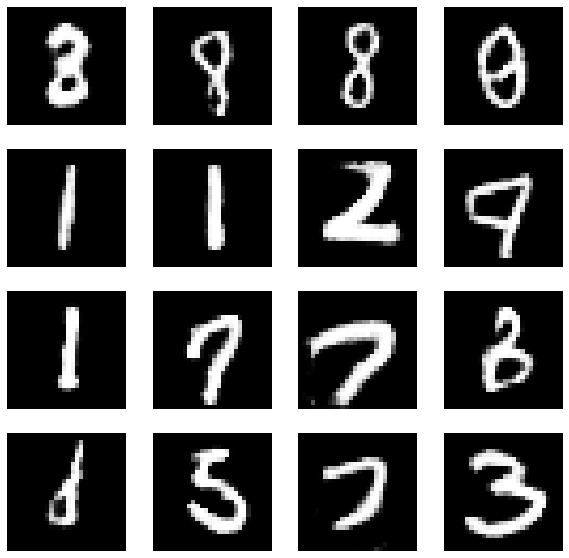

19000: [discriminator loss: 0.5842896103858948, acc: 0.7109375] [gan loss: 1.174758, acc: 0.296875]
19001: [discriminator loss: 0.5464385747909546, acc: 0.734375] [gan loss: 1.294883, acc: 0.234375]
19002: [discriminator loss: 0.5709476470947266, acc: 0.71875] [gan loss: 1.037210, acc: 0.328125]
19003: [discriminator loss: 0.4677795469760895, acc: 0.75] [gan loss: 1.187413, acc: 0.203125]
19004: [discriminator loss: 0.5281109809875488, acc: 0.7109375] [gan loss: 1.208273, acc: 0.187500]
19005: [discriminator loss: 0.5035922527313232, acc: 0.734375] [gan loss: 1.285995, acc: 0.140625]
19006: [discriminator loss: 0.560157835483551, acc: 0.6875] [gan loss: 0.965331, acc: 0.375000]
19007: [discriminator loss: 0.5163426399230957, acc: 0.7578125] [gan loss: 1.338004, acc: 0.296875]
19008: [discriminator loss: 0.5551464557647705, acc: 0.7421875] [gan loss: 0.946410, acc: 0.343750]
19009: [discriminator loss: 0.5432853698730469, acc: 0.734375] [gan loss: 1.591706, acc: 0.125000]
19010: [discri

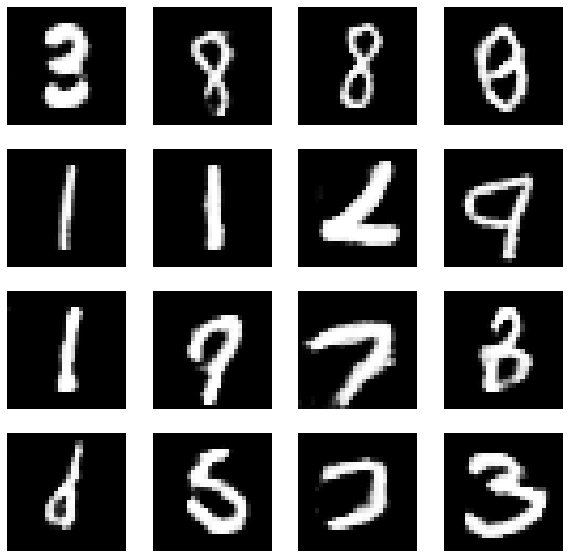

19500: [discriminator loss: 0.5509822964668274, acc: 0.7109375] [gan loss: 1.386815, acc: 0.187500]
19501: [discriminator loss: 0.5431597232818604, acc: 0.703125] [gan loss: 1.051624, acc: 0.218750]
19502: [discriminator loss: 0.5492438673973083, acc: 0.7109375] [gan loss: 1.216835, acc: 0.265625]
19503: [discriminator loss: 0.5558157563209534, acc: 0.7109375] [gan loss: 1.242101, acc: 0.250000]
19504: [discriminator loss: 0.6370203495025635, acc: 0.625] [gan loss: 1.268189, acc: 0.171875]
19505: [discriminator loss: 0.5129808783531189, acc: 0.75] [gan loss: 1.079876, acc: 0.296875]
19506: [discriminator loss: 0.5983768105506897, acc: 0.6640625] [gan loss: 1.212682, acc: 0.125000]
19507: [discriminator loss: 0.5393010377883911, acc: 0.75] [gan loss: 1.022800, acc: 0.281250]
19508: [discriminator loss: 0.6188690066337585, acc: 0.625] [gan loss: 1.353600, acc: 0.281250]
19509: [discriminator loss: 0.48387864232063293, acc: 0.828125] [gan loss: 1.065641, acc: 0.312500]
19510: [discriminat

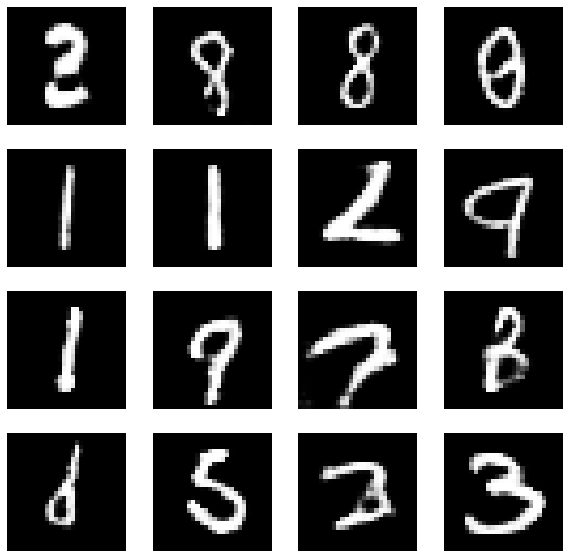

20000: [discriminator loss: 0.65631103515625, acc: 0.65625] [gan loss: 0.922653, acc: 0.421875]
20001: [discriminator loss: 0.5667261481285095, acc: 0.703125] [gan loss: 1.429087, acc: 0.203125]
20002: [discriminator loss: 0.5874147415161133, acc: 0.6484375] [gan loss: 1.104471, acc: 0.375000]
20003: [discriminator loss: 0.574764609336853, acc: 0.6953125] [gan loss: 1.435138, acc: 0.171875]
20004: [discriminator loss: 0.5428365468978882, acc: 0.703125] [gan loss: 1.111404, acc: 0.328125]
20005: [discriminator loss: 0.5645438432693481, acc: 0.7109375] [gan loss: 1.210688, acc: 0.250000]
20006: [discriminator loss: 0.5391242504119873, acc: 0.7265625] [gan loss: 1.048225, acc: 0.343750]
20007: [discriminator loss: 0.5183068513870239, acc: 0.734375] [gan loss: 1.122592, acc: 0.296875]
20008: [discriminator loss: 0.5743159055709839, acc: 0.671875] [gan loss: 1.006038, acc: 0.359375]
20009: [discriminator loss: 0.5158438682556152, acc: 0.75] [gan loss: 1.291368, acc: 0.203125]
20010: [discri

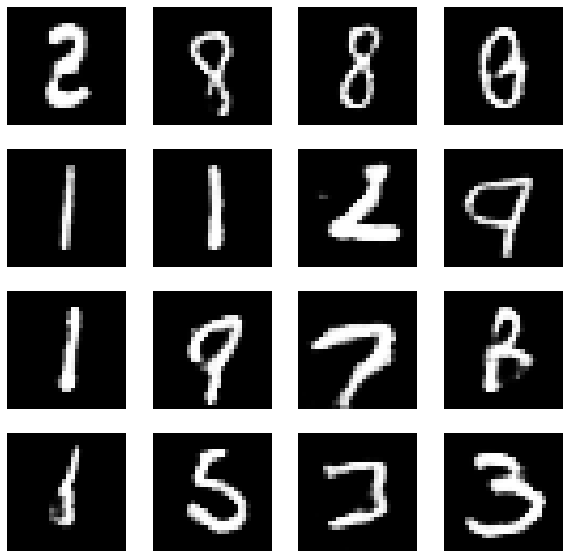

20500: [discriminator loss: 0.5254342555999756, acc: 0.734375] [gan loss: 1.231532, acc: 0.234375]
20501: [discriminator loss: 0.47011464834213257, acc: 0.7421875] [gan loss: 0.957025, acc: 0.296875]
20502: [discriminator loss: 0.5190944075584412, acc: 0.6953125] [gan loss: 1.146122, acc: 0.296875]
20503: [discriminator loss: 0.546298086643219, acc: 0.6640625] [gan loss: 1.001014, acc: 0.406250]
20504: [discriminator loss: 0.5274686217308044, acc: 0.7109375] [gan loss: 1.337615, acc: 0.250000]
20505: [discriminator loss: 0.5988377928733826, acc: 0.71875] [gan loss: 1.452303, acc: 0.140625]
20506: [discriminator loss: 0.5549170970916748, acc: 0.7265625] [gan loss: 1.287922, acc: 0.250000]
20507: [discriminator loss: 0.5451432466506958, acc: 0.7109375] [gan loss: 1.040239, acc: 0.281250]
20508: [discriminator loss: 0.5306044220924377, acc: 0.7421875] [gan loss: 1.173530, acc: 0.296875]
20509: [discriminator loss: 0.5642105340957642, acc: 0.6796875] [gan loss: 1.340759, acc: 0.265625]
205

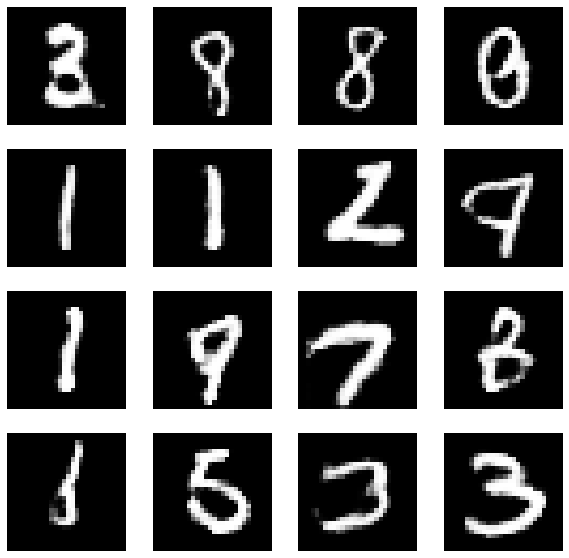

21000: [discriminator loss: 0.5049669742584229, acc: 0.7109375] [gan loss: 0.993325, acc: 0.328125]
21001: [discriminator loss: 0.4901044964790344, acc: 0.71875] [gan loss: 1.351837, acc: 0.093750]
21002: [discriminator loss: 0.5424807667732239, acc: 0.7265625] [gan loss: 0.934850, acc: 0.484375]
21003: [discriminator loss: 0.5569255948066711, acc: 0.6875] [gan loss: 1.612280, acc: 0.062500]
21004: [discriminator loss: 0.5183218121528625, acc: 0.7421875] [gan loss: 1.011255, acc: 0.281250]
21005: [discriminator loss: 0.6271644830703735, acc: 0.6484375] [gan loss: 1.559717, acc: 0.140625]
21006: [discriminator loss: 0.48636531829833984, acc: 0.7421875] [gan loss: 1.183552, acc: 0.203125]
21007: [discriminator loss: 0.5533902645111084, acc: 0.7109375] [gan loss: 1.136881, acc: 0.234375]
21008: [discriminator loss: 0.5592702031135559, acc: 0.734375] [gan loss: 1.140011, acc: 0.250000]
21009: [discriminator loss: 0.5411714911460876, acc: 0.71875] [gan loss: 1.113346, acc: 0.265625]
21010: 

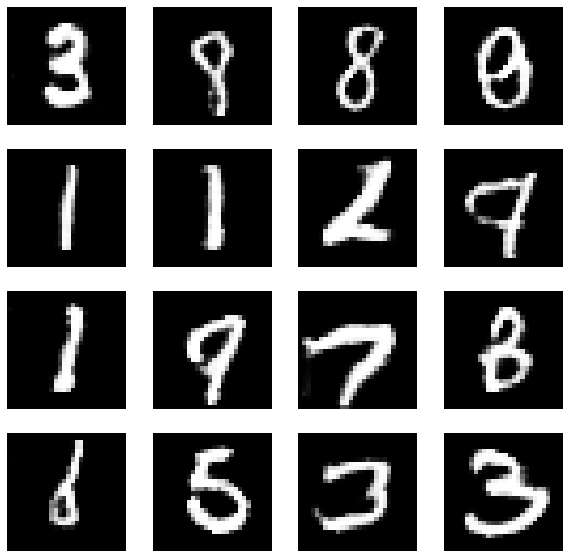

21500: [discriminator loss: 0.6117075681686401, acc: 0.6640625] [gan loss: 1.662469, acc: 0.125000]
21501: [discriminator loss: 0.628941535949707, acc: 0.6484375] [gan loss: 0.737232, acc: 0.531250]
21502: [discriminator loss: 0.5866525173187256, acc: 0.6953125] [gan loss: 1.675382, acc: 0.093750]
21503: [discriminator loss: 0.5229105353355408, acc: 0.75] [gan loss: 1.158434, acc: 0.312500]
21504: [discriminator loss: 0.6450242400169373, acc: 0.65625] [gan loss: 1.147646, acc: 0.296875]
21505: [discriminator loss: 0.5126714706420898, acc: 0.7421875] [gan loss: 1.232554, acc: 0.250000]
21506: [discriminator loss: 0.5354160666465759, acc: 0.71875] [gan loss: 1.167736, acc: 0.296875]
21507: [discriminator loss: 0.5211862325668335, acc: 0.6953125] [gan loss: 1.306921, acc: 0.171875]
21508: [discriminator loss: 0.5609750151634216, acc: 0.71875] [gan loss: 0.831447, acc: 0.500000]
21509: [discriminator loss: 0.5804250836372375, acc: 0.703125] [gan loss: 1.548001, acc: 0.093750]
21510: [discr

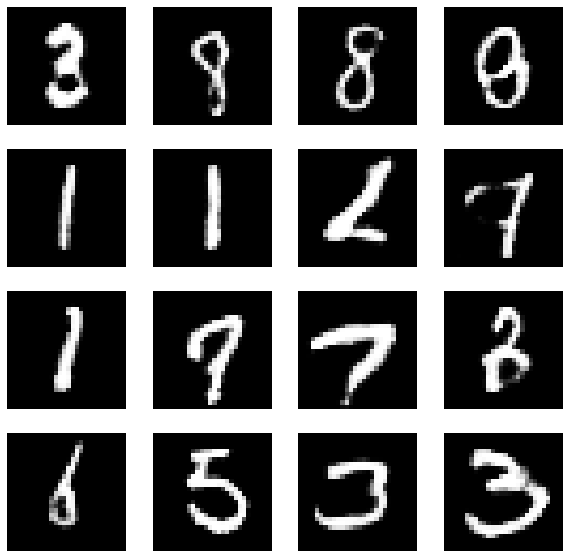

22000: [discriminator loss: 0.5523471236228943, acc: 0.703125] [gan loss: 1.526460, acc: 0.171875]
22001: [discriminator loss: 0.5458283424377441, acc: 0.734375] [gan loss: 0.923469, acc: 0.406250]
22002: [discriminator loss: 0.5886880159378052, acc: 0.671875] [gan loss: 1.320878, acc: 0.250000]
22003: [discriminator loss: 0.5506438612937927, acc: 0.734375] [gan loss: 1.122654, acc: 0.312500]
22004: [discriminator loss: 0.5162388682365417, acc: 0.7421875] [gan loss: 1.040636, acc: 0.375000]
22005: [discriminator loss: 0.5252988934516907, acc: 0.7421875] [gan loss: 1.363180, acc: 0.203125]
22006: [discriminator loss: 0.4968831539154053, acc: 0.7421875] [gan loss: 1.011425, acc: 0.421875]
22007: [discriminator loss: 0.5295678973197937, acc: 0.7421875] [gan loss: 1.608709, acc: 0.093750]
22008: [discriminator loss: 0.5585773587226868, acc: 0.640625] [gan loss: 1.047493, acc: 0.234375]
22009: [discriminator loss: 0.584020733833313, acc: 0.640625] [gan loss: 1.397734, acc: 0.156250]
22010: 

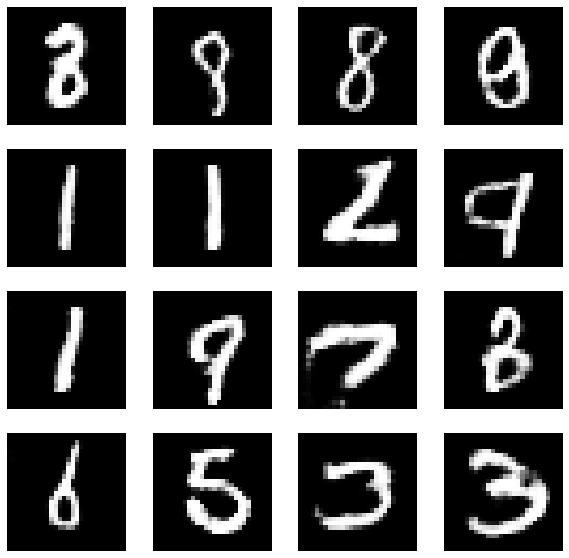

22500: [discriminator loss: 0.5629772543907166, acc: 0.71875] [gan loss: 1.031052, acc: 0.375000]
22501: [discriminator loss: 0.5502268075942993, acc: 0.6953125] [gan loss: 1.527765, acc: 0.125000]
22502: [discriminator loss: 0.48610877990722656, acc: 0.7421875] [gan loss: 1.225875, acc: 0.234375]
22503: [discriminator loss: 0.5439979434013367, acc: 0.71875] [gan loss: 1.658846, acc: 0.093750]
22504: [discriminator loss: 0.6180247068405151, acc: 0.671875] [gan loss: 0.825058, acc: 0.484375]
22505: [discriminator loss: 0.5338348746299744, acc: 0.71875] [gan loss: 1.196870, acc: 0.296875]
22506: [discriminator loss: 0.6115320324897766, acc: 0.6328125] [gan loss: 1.077092, acc: 0.359375]
22507: [discriminator loss: 0.5791784524917603, acc: 0.6796875] [gan loss: 1.220685, acc: 0.218750]
22508: [discriminator loss: 0.5183688402175903, acc: 0.6875] [gan loss: 1.200462, acc: 0.328125]
22509: [discriminator loss: 0.5449917912483215, acc: 0.7109375] [gan loss: 1.469098, acc: 0.140625]
22510: [d

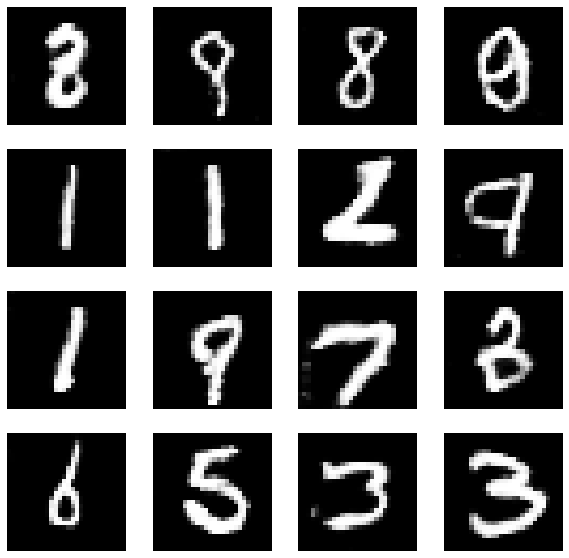

23000: [discriminator loss: 0.5321248173713684, acc: 0.7421875] [gan loss: 1.009277, acc: 0.328125]
23001: [discriminator loss: 0.6721824407577515, acc: 0.6484375] [gan loss: 1.301824, acc: 0.156250]
23002: [discriminator loss: 0.5522568225860596, acc: 0.7265625] [gan loss: 0.913865, acc: 0.421875]
23003: [discriminator loss: 0.47363436222076416, acc: 0.765625] [gan loss: 1.179041, acc: 0.281250]
23004: [discriminator loss: 0.5398597717285156, acc: 0.7109375] [gan loss: 0.922826, acc: 0.406250]
23005: [discriminator loss: 0.5968953967094421, acc: 0.6796875] [gan loss: 1.431939, acc: 0.171875]
23006: [discriminator loss: 0.5714663863182068, acc: 0.640625] [gan loss: 0.958670, acc: 0.453125]
23007: [discriminator loss: 0.6108454465866089, acc: 0.65625] [gan loss: 1.584899, acc: 0.140625]
23008: [discriminator loss: 0.4967329800128937, acc: 0.7734375] [gan loss: 1.077404, acc: 0.359375]
23009: [discriminator loss: 0.5415440797805786, acc: 0.765625] [gan loss: 1.497910, acc: 0.125000]
2301

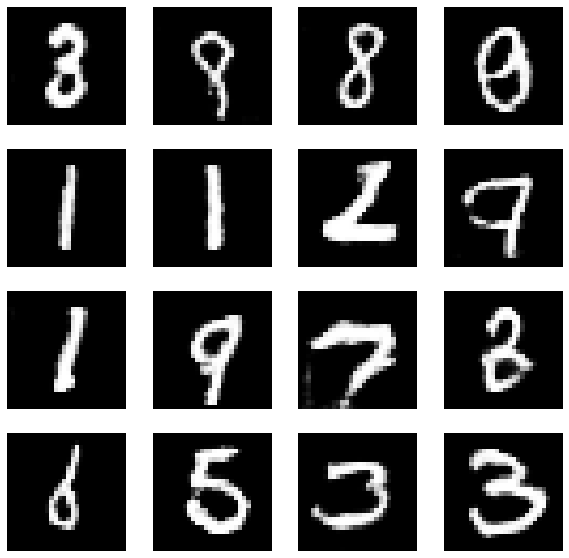

23500: [discriminator loss: 0.5195752382278442, acc: 0.7265625] [gan loss: 1.203981, acc: 0.281250]
23501: [discriminator loss: 0.5451221466064453, acc: 0.75] [gan loss: 1.419341, acc: 0.140625]
23502: [discriminator loss: 0.5229663848876953, acc: 0.6953125] [gan loss: 0.903424, acc: 0.468750]
23503: [discriminator loss: 0.5263199806213379, acc: 0.6796875] [gan loss: 1.446070, acc: 0.203125]
23504: [discriminator loss: 0.5704107880592346, acc: 0.71875] [gan loss: 0.734316, acc: 0.531250]
23505: [discriminator loss: 0.5550833940505981, acc: 0.7109375] [gan loss: 1.398252, acc: 0.171875]
23506: [discriminator loss: 0.5385441184043884, acc: 0.6796875] [gan loss: 1.087124, acc: 0.375000]
23507: [discriminator loss: 0.50227952003479, acc: 0.75] [gan loss: 1.303167, acc: 0.218750]
23508: [discriminator loss: 0.5796552896499634, acc: 0.703125] [gan loss: 0.886331, acc: 0.421875]
23509: [discriminator loss: 0.5434608459472656, acc: 0.703125] [gan loss: 1.588085, acc: 0.125000]
23510: [discrimi

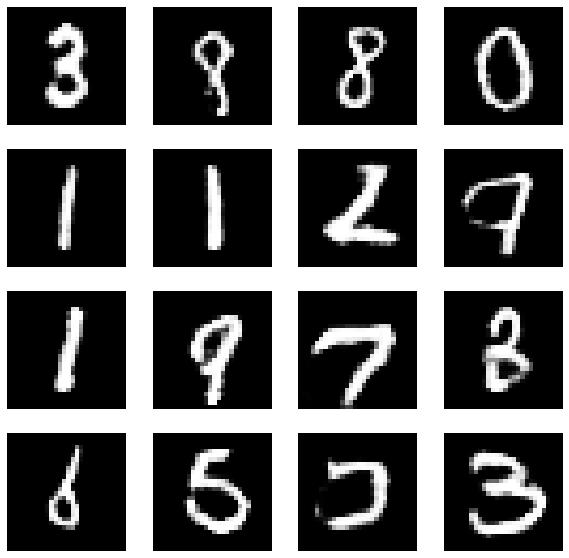

24000: [discriminator loss: 0.5191928744316101, acc: 0.7578125] [gan loss: 1.338895, acc: 0.140625]
24001: [discriminator loss: 0.42931145429611206, acc: 0.8359375] [gan loss: 1.290231, acc: 0.187500]
24002: [discriminator loss: 0.49298593401908875, acc: 0.7734375] [gan loss: 1.301859, acc: 0.234375]
24003: [discriminator loss: 0.540303111076355, acc: 0.7109375] [gan loss: 0.990654, acc: 0.390625]
24004: [discriminator loss: 0.498534619808197, acc: 0.7578125] [gan loss: 1.166037, acc: 0.250000]
24005: [discriminator loss: 0.5054789185523987, acc: 0.7578125] [gan loss: 1.114043, acc: 0.359375]
24006: [discriminator loss: 0.5228848457336426, acc: 0.7421875] [gan loss: 1.372213, acc: 0.140625]
24007: [discriminator loss: 0.5199097394943237, acc: 0.7421875] [gan loss: 0.985456, acc: 0.421875]
24008: [discriminator loss: 0.5329070687294006, acc: 0.7109375] [gan loss: 1.152495, acc: 0.296875]
24009: [discriminator loss: 0.562384843826294, acc: 0.6875] [gan loss: 1.275104, acc: 0.203125]
2401

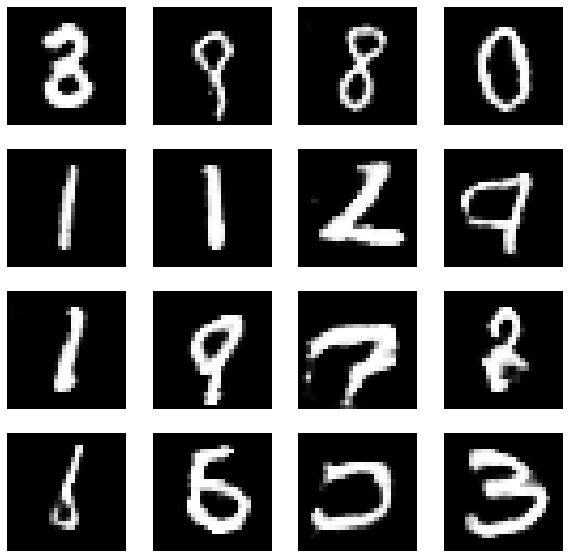

24500: [discriminator loss: 0.5659286379814148, acc: 0.7265625] [gan loss: 0.835901, acc: 0.453125]
24501: [discriminator loss: 0.5278271436691284, acc: 0.7109375] [gan loss: 1.509148, acc: 0.093750]
24502: [discriminator loss: 0.5423031449317932, acc: 0.671875] [gan loss: 0.927395, acc: 0.406250]
24503: [discriminator loss: 0.5976211428642273, acc: 0.6875] [gan loss: 1.214058, acc: 0.234375]
24504: [discriminator loss: 0.44626978039741516, acc: 0.8359375] [gan loss: 1.190458, acc: 0.203125]
24505: [discriminator loss: 0.551181972026825, acc: 0.6796875] [gan loss: 1.219066, acc: 0.218750]
24506: [discriminator loss: 0.5845338702201843, acc: 0.6875] [gan loss: 1.052356, acc: 0.296875]
24507: [discriminator loss: 0.5752111077308655, acc: 0.7421875] [gan loss: 1.206237, acc: 0.234375]
24508: [discriminator loss: 0.5047363042831421, acc: 0.765625] [gan loss: 1.272147, acc: 0.281250]
24509: [discriminator loss: 0.5901881456375122, acc: 0.6953125] [gan loss: 1.369445, acc: 0.187500]
24510: [

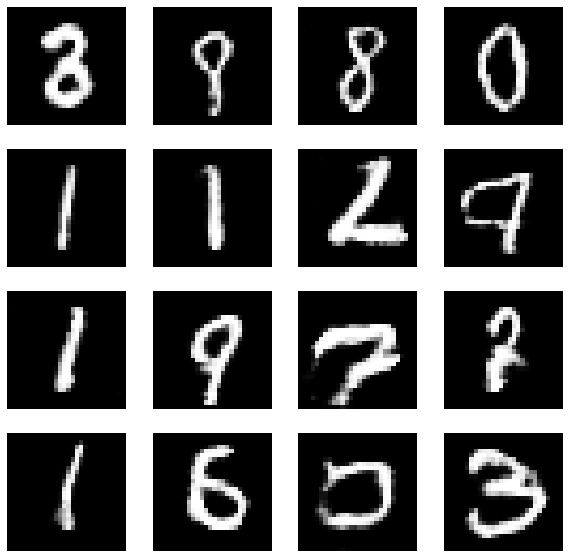

25000: [discriminator loss: 0.5479605197906494, acc: 0.6875] [gan loss: 0.864736, acc: 0.484375]
25001: [discriminator loss: 0.5756099224090576, acc: 0.6484375] [gan loss: 1.738928, acc: 0.046875]
25002: [discriminator loss: 0.6291542649269104, acc: 0.6015625] [gan loss: 0.865460, acc: 0.531250]
25003: [discriminator loss: 0.5025179386138916, acc: 0.765625] [gan loss: 1.256704, acc: 0.265625]
25004: [discriminator loss: 0.47968292236328125, acc: 0.765625] [gan loss: 1.026611, acc: 0.375000]
25005: [discriminator loss: 0.5287070274353027, acc: 0.7265625] [gan loss: 1.318966, acc: 0.203125]
25006: [discriminator loss: 0.5662063360214233, acc: 0.7109375] [gan loss: 1.018543, acc: 0.312500]
25007: [discriminator loss: 0.5310231447219849, acc: 0.734375] [gan loss: 1.318354, acc: 0.125000]
25008: [discriminator loss: 0.4740053415298462, acc: 0.7578125] [gan loss: 1.311517, acc: 0.234375]
25009: [discriminator loss: 0.5919002890586853, acc: 0.6484375] [gan loss: 1.422353, acc: 0.125000]
25010

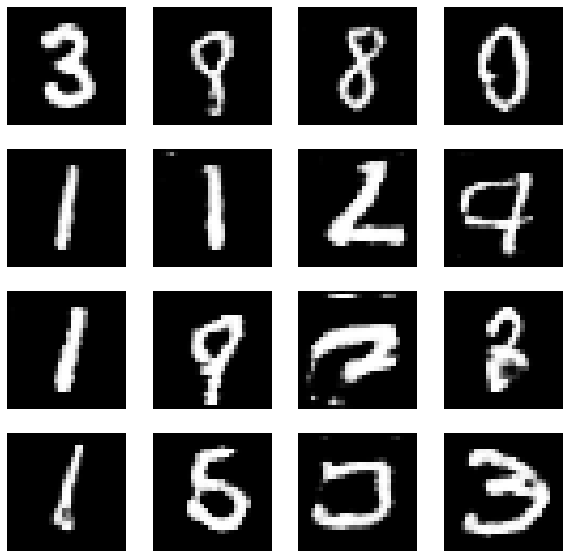

25500: [discriminator loss: 0.5342625379562378, acc: 0.71875] [gan loss: 0.896467, acc: 0.375000]
25501: [discriminator loss: 0.5181299448013306, acc: 0.7578125] [gan loss: 1.205031, acc: 0.234375]
25502: [discriminator loss: 0.5498952865600586, acc: 0.7265625] [gan loss: 1.053276, acc: 0.312500]
25503: [discriminator loss: 0.5132735967636108, acc: 0.765625] [gan loss: 1.512201, acc: 0.203125]
25504: [discriminator loss: 0.5451952219009399, acc: 0.671875] [gan loss: 1.115708, acc: 0.265625]
25505: [discriminator loss: 0.5238274931907654, acc: 0.7109375] [gan loss: 1.453598, acc: 0.109375]
25506: [discriminator loss: 0.5725815296173096, acc: 0.65625] [gan loss: 1.046535, acc: 0.359375]
25507: [discriminator loss: 0.5361543893814087, acc: 0.78125] [gan loss: 1.028625, acc: 0.343750]
25508: [discriminator loss: 0.5312418937683105, acc: 0.7265625] [gan loss: 0.922653, acc: 0.390625]
25509: [discriminator loss: 0.5345751047134399, acc: 0.734375] [gan loss: 1.303354, acc: 0.312500]
25510: [d

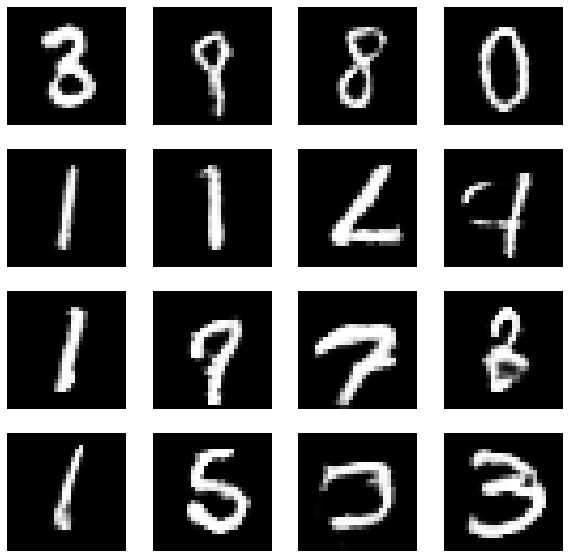

26000: [discriminator loss: 0.571745753288269, acc: 0.6953125] [gan loss: 1.650787, acc: 0.093750]
26001: [discriminator loss: 0.5750559568405151, acc: 0.7109375] [gan loss: 0.579554, acc: 0.781250]
26002: [discriminator loss: 0.5874577164649963, acc: 0.671875] [gan loss: 1.642151, acc: 0.187500]
26003: [discriminator loss: 0.5986290574073792, acc: 0.671875] [gan loss: 1.184680, acc: 0.203125]
26004: [discriminator loss: 0.5368349552154541, acc: 0.71875] [gan loss: 1.088346, acc: 0.312500]
26005: [discriminator loss: 0.5086524486541748, acc: 0.734375] [gan loss: 1.244513, acc: 0.250000]
26006: [discriminator loss: 0.5315049290657043, acc: 0.71875] [gan loss: 1.578041, acc: 0.078125]
26007: [discriminator loss: 0.5205111503601074, acc: 0.703125] [gan loss: 1.062961, acc: 0.343750]
26008: [discriminator loss: 0.5244954228401184, acc: 0.7265625] [gan loss: 1.210921, acc: 0.296875]
26009: [discriminator loss: 0.5464087128639221, acc: 0.7265625] [gan loss: 1.034398, acc: 0.312500]
26010: [d

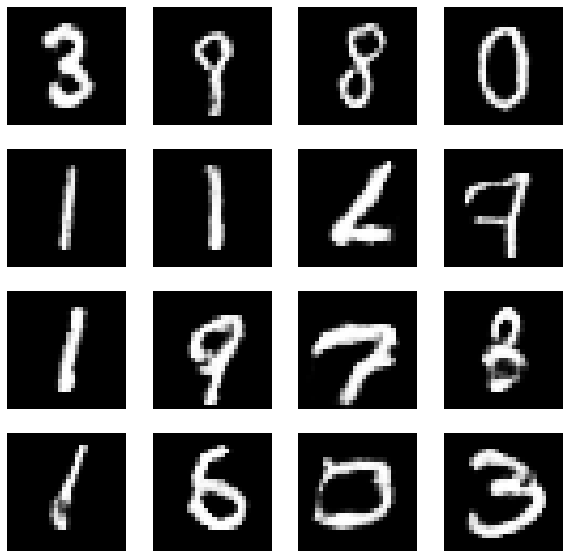

26500: [discriminator loss: 0.4752545952796936, acc: 0.75] [gan loss: 1.150279, acc: 0.328125]
26501: [discriminator loss: 0.4798316955566406, acc: 0.8125] [gan loss: 1.334277, acc: 0.250000]
26502: [discriminator loss: 0.5133171677589417, acc: 0.71875] [gan loss: 0.953031, acc: 0.406250]
26503: [discriminator loss: 0.5176581144332886, acc: 0.796875] [gan loss: 1.585675, acc: 0.093750]
26504: [discriminator loss: 0.5780154466629028, acc: 0.6875] [gan loss: 1.040470, acc: 0.375000]
26505: [discriminator loss: 0.5135688185691833, acc: 0.75] [gan loss: 1.162522, acc: 0.296875]
26506: [discriminator loss: 0.5225767493247986, acc: 0.71875] [gan loss: 1.000152, acc: 0.328125]
26507: [discriminator loss: 0.49769651889801025, acc: 0.765625] [gan loss: 1.148427, acc: 0.312500]
26508: [discriminator loss: 0.5297545194625854, acc: 0.7109375] [gan loss: 1.111408, acc: 0.328125]
26509: [discriminator loss: 0.5078397989273071, acc: 0.7265625] [gan loss: 1.201421, acc: 0.265625]
26510: [discriminator

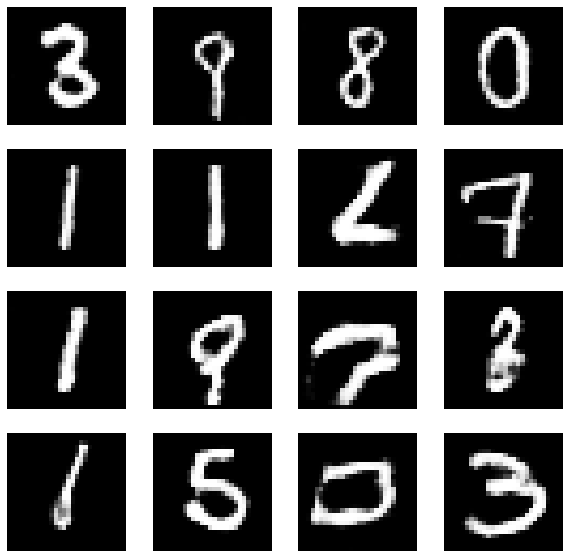

27000: [discriminator loss: 0.5458812713623047, acc: 0.6796875] [gan loss: 1.030796, acc: 0.359375]
27001: [discriminator loss: 0.5799294710159302, acc: 0.7109375] [gan loss: 1.295181, acc: 0.203125]
27002: [discriminator loss: 0.5478373169898987, acc: 0.734375] [gan loss: 1.023540, acc: 0.328125]
27003: [discriminator loss: 0.6007347106933594, acc: 0.6953125] [gan loss: 1.197773, acc: 0.218750]
27004: [discriminator loss: 0.5528712272644043, acc: 0.71875] [gan loss: 1.327394, acc: 0.187500]
27005: [discriminator loss: 0.5036876201629639, acc: 0.75] [gan loss: 1.039784, acc: 0.296875]
27006: [discriminator loss: 0.5403441190719604, acc: 0.6484375] [gan loss: 1.173654, acc: 0.218750]
27007: [discriminator loss: 0.5607216358184814, acc: 0.6875] [gan loss: 1.071400, acc: 0.343750]
27008: [discriminator loss: 0.5603718757629395, acc: 0.6875] [gan loss: 1.350536, acc: 0.171875]
27009: [discriminator loss: 0.6038822531700134, acc: 0.6796875] [gan loss: 0.915444, acc: 0.453125]
27010: [discri

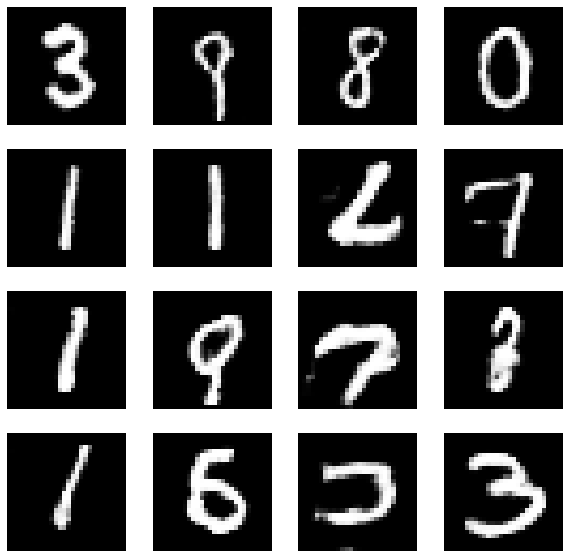

27500: [discriminator loss: 0.5799378156661987, acc: 0.65625] [gan loss: 1.598079, acc: 0.109375]
27501: [discriminator loss: 0.6175810694694519, acc: 0.609375] [gan loss: 0.743441, acc: 0.515625]
27502: [discriminator loss: 0.5676923990249634, acc: 0.671875] [gan loss: 1.261085, acc: 0.187500]
27503: [discriminator loss: 0.538185715675354, acc: 0.703125] [gan loss: 0.984515, acc: 0.296875]
27504: [discriminator loss: 0.5512240529060364, acc: 0.734375] [gan loss: 1.460026, acc: 0.156250]
27505: [discriminator loss: 0.5761533975601196, acc: 0.6796875] [gan loss: 0.980791, acc: 0.453125]
27506: [discriminator loss: 0.4977979063987732, acc: 0.7421875] [gan loss: 1.685423, acc: 0.078125]
27507: [discriminator loss: 0.5924573540687561, acc: 0.6640625] [gan loss: 1.009606, acc: 0.390625]
27508: [discriminator loss: 0.5472396016120911, acc: 0.7265625] [gan loss: 1.438950, acc: 0.265625]
27509: [discriminator loss: 0.49724966287612915, acc: 0.78125] [gan loss: 0.913435, acc: 0.390625]
27510: [

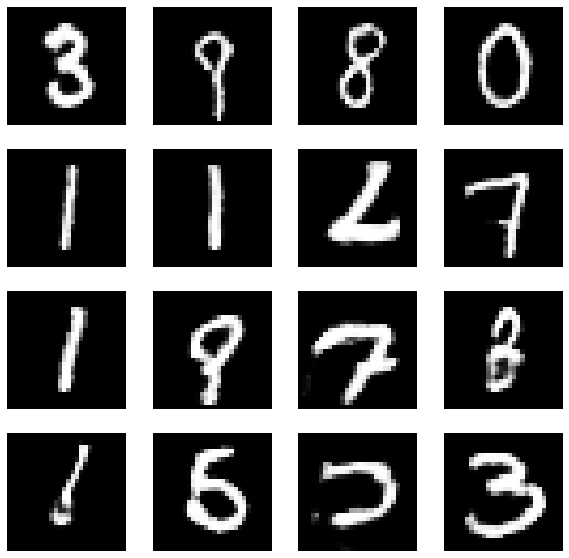

28000: [discriminator loss: 0.4781140983104706, acc: 0.7734375] [gan loss: 1.221376, acc: 0.234375]
28001: [discriminator loss: 0.4785451889038086, acc: 0.7421875] [gan loss: 1.282536, acc: 0.171875]
28002: [discriminator loss: 0.5571814775466919, acc: 0.703125] [gan loss: 1.384606, acc: 0.187500]
28003: [discriminator loss: 0.50504469871521, acc: 0.7421875] [gan loss: 1.212532, acc: 0.265625]
28004: [discriminator loss: 0.6023173928260803, acc: 0.6484375] [gan loss: 0.783802, acc: 0.484375]
28005: [discriminator loss: 0.595067024230957, acc: 0.6875] [gan loss: 1.816982, acc: 0.062500]
28006: [discriminator loss: 0.6372804045677185, acc: 0.640625] [gan loss: 0.708912, acc: 0.546875]
28007: [discriminator loss: 0.5638867616653442, acc: 0.703125] [gan loss: 1.555625, acc: 0.078125]
28008: [discriminator loss: 0.5944536924362183, acc: 0.6953125] [gan loss: 1.070228, acc: 0.328125]
28009: [discriminator loss: 0.5228092670440674, acc: 0.796875] [gan loss: 1.274094, acc: 0.218750]
28010: [di

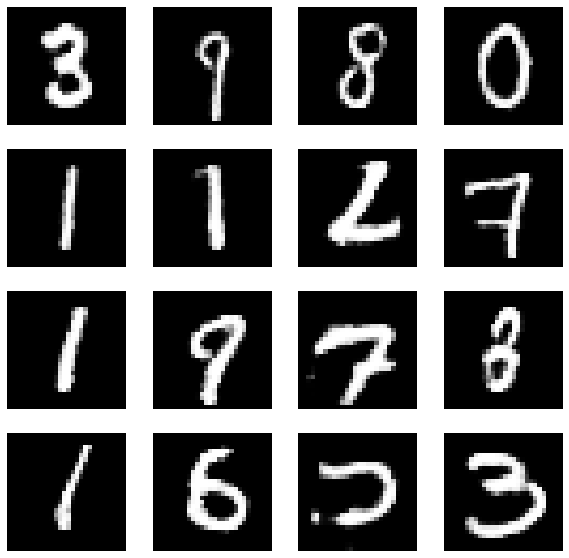

28500: [discriminator loss: 0.602369487285614, acc: 0.640625] [gan loss: 0.879638, acc: 0.515625]
28501: [discriminator loss: 0.5853695869445801, acc: 0.6328125] [gan loss: 1.457576, acc: 0.125000]
28502: [discriminator loss: 0.5309768915176392, acc: 0.6875] [gan loss: 1.005689, acc: 0.453125]
28503: [discriminator loss: 0.4648456871509552, acc: 0.8203125] [gan loss: 1.557577, acc: 0.078125]
28504: [discriminator loss: 0.6134301424026489, acc: 0.6484375] [gan loss: 0.906137, acc: 0.421875]
28505: [discriminator loss: 0.5049585103988647, acc: 0.734375] [gan loss: 1.365087, acc: 0.125000]
28506: [discriminator loss: 0.5221292972564697, acc: 0.7109375] [gan loss: 0.973985, acc: 0.406250]
28507: [discriminator loss: 0.5610703229904175, acc: 0.7109375] [gan loss: 1.534888, acc: 0.234375]
28508: [discriminator loss: 0.5474128127098083, acc: 0.7109375] [gan loss: 0.983392, acc: 0.453125]
28509: [discriminator loss: 0.5454632639884949, acc: 0.7421875] [gan loss: 1.382361, acc: 0.187500]
28510:

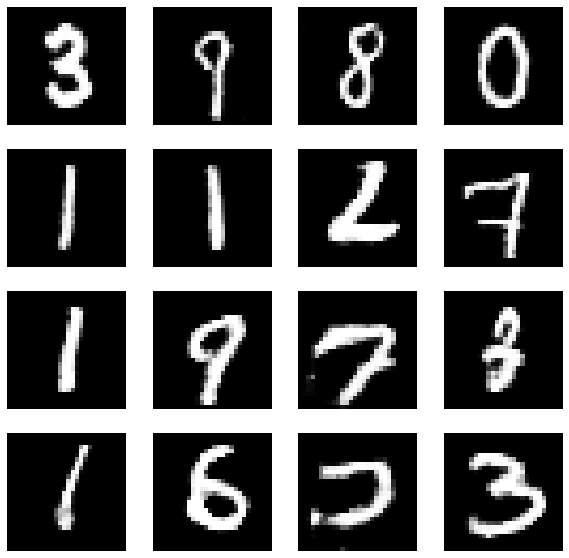

29000: [discriminator loss: 0.5608713626861572, acc: 0.6953125] [gan loss: 0.893517, acc: 0.359375]
29001: [discriminator loss: 0.5170422792434692, acc: 0.8046875] [gan loss: 1.547363, acc: 0.156250]
29002: [discriminator loss: 0.5176160335540771, acc: 0.71875] [gan loss: 1.145776, acc: 0.234375]
29003: [discriminator loss: 0.521634578704834, acc: 0.75] [gan loss: 1.522882, acc: 0.093750]
29004: [discriminator loss: 0.5813955068588257, acc: 0.6953125] [gan loss: 0.751218, acc: 0.546875]
29005: [discriminator loss: 0.5920374989509583, acc: 0.671875] [gan loss: 1.564086, acc: 0.203125]
29006: [discriminator loss: 0.5587441921234131, acc: 0.7109375] [gan loss: 0.986817, acc: 0.453125]
29007: [discriminator loss: 0.5558191537857056, acc: 0.7109375] [gan loss: 1.412088, acc: 0.171875]
29008: [discriminator loss: 0.5860954523086548, acc: 0.6875] [gan loss: 1.180161, acc: 0.187500]
29009: [discriminator loss: 0.5232433080673218, acc: 0.75] [gan loss: 1.104931, acc: 0.265625]
29010: [discrimin

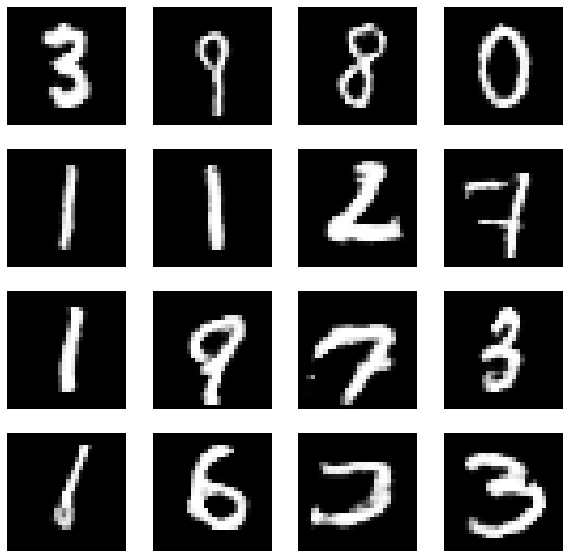

29500: [discriminator loss: 0.5745329856872559, acc: 0.703125] [gan loss: 0.949334, acc: 0.453125]
29501: [discriminator loss: 0.46191054582595825, acc: 0.765625] [gan loss: 1.413381, acc: 0.234375]
29502: [discriminator loss: 0.5120424032211304, acc: 0.703125] [gan loss: 1.102498, acc: 0.406250]
29503: [discriminator loss: 0.5232009887695312, acc: 0.734375] [gan loss: 1.332762, acc: 0.265625]
29504: [discriminator loss: 0.5284669995307922, acc: 0.7109375] [gan loss: 1.112895, acc: 0.328125]
29505: [discriminator loss: 0.5213441252708435, acc: 0.734375] [gan loss: 1.222055, acc: 0.265625]
29506: [discriminator loss: 0.500998854637146, acc: 0.734375] [gan loss: 1.139066, acc: 0.265625]
29507: [discriminator loss: 0.5442694425582886, acc: 0.71875] [gan loss: 1.310786, acc: 0.218750]
29508: [discriminator loss: 0.46088507771492004, acc: 0.7734375] [gan loss: 0.756327, acc: 0.562500]
29509: [discriminator loss: 0.5850878357887268, acc: 0.703125] [gan loss: 1.607688, acc: 0.156250]
29510: [

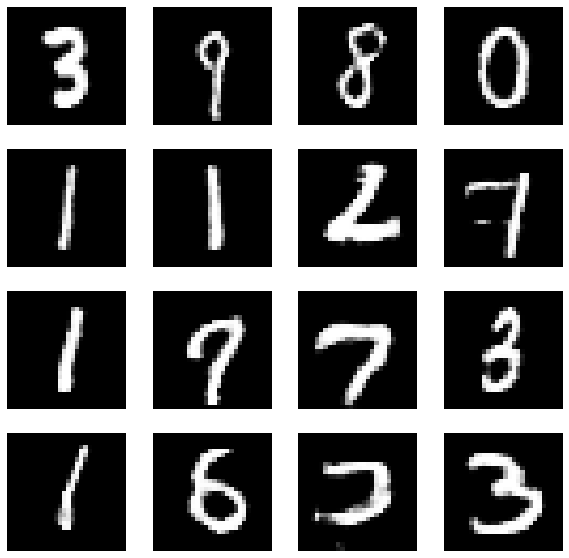

30000: [discriminator loss: 0.5205976366996765, acc: 0.7578125] [gan loss: 1.272300, acc: 0.265625]
30001: [discriminator loss: 0.5435730218887329, acc: 0.6875] [gan loss: 1.194221, acc: 0.312500]
30002: [discriminator loss: 0.5636798143386841, acc: 0.6953125] [gan loss: 1.139148, acc: 0.296875]
30003: [discriminator loss: 0.5173498392105103, acc: 0.75] [gan loss: 1.288576, acc: 0.281250]
30004: [discriminator loss: 0.5088565945625305, acc: 0.75] [gan loss: 1.296358, acc: 0.281250]
30005: [discriminator loss: 0.5155923962593079, acc: 0.7578125] [gan loss: 1.314521, acc: 0.250000]
30006: [discriminator loss: 0.5460845232009888, acc: 0.71875] [gan loss: 1.177107, acc: 0.328125]
30007: [discriminator loss: 0.4945947229862213, acc: 0.796875] [gan loss: 1.155856, acc: 0.312500]
30008: [discriminator loss: 0.47114595770835876, acc: 0.8046875] [gan loss: 1.428562, acc: 0.234375]
30009: [discriminator loss: 0.48252710700035095, acc: 0.7890625] [gan loss: 0.890226, acc: 0.500000]
30010: [discri

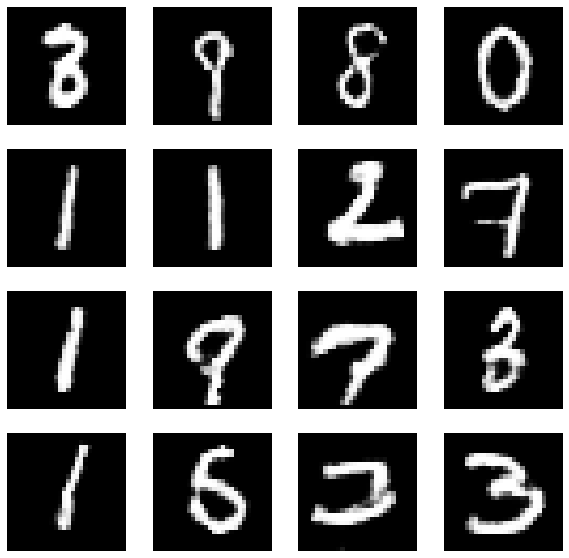

30500: [discriminator loss: 0.46358945965766907, acc: 0.8046875] [gan loss: 1.153135, acc: 0.265625]
30501: [discriminator loss: 0.5548424124717712, acc: 0.7109375] [gan loss: 1.125497, acc: 0.281250]
30502: [discriminator loss: 0.5609734058380127, acc: 0.7109375] [gan loss: 0.925675, acc: 0.406250]
30503: [discriminator loss: 0.6353721618652344, acc: 0.640625] [gan loss: 1.929516, acc: 0.046875]
30504: [discriminator loss: 0.5645625591278076, acc: 0.671875] [gan loss: 0.907384, acc: 0.453125]
30505: [discriminator loss: 0.5770398378372192, acc: 0.7265625] [gan loss: 1.503577, acc: 0.140625]
30506: [discriminator loss: 0.591549277305603, acc: 0.6328125] [gan loss: 1.298545, acc: 0.203125]
30507: [discriminator loss: 0.5380240678787231, acc: 0.71875] [gan loss: 1.146085, acc: 0.265625]
30508: [discriminator loss: 0.5300177931785583, acc: 0.71875] [gan loss: 1.245388, acc: 0.218750]
30509: [discriminator loss: 0.5753041505813599, acc: 0.7265625] [gan loss: 1.056579, acc: 0.390625]
30510:

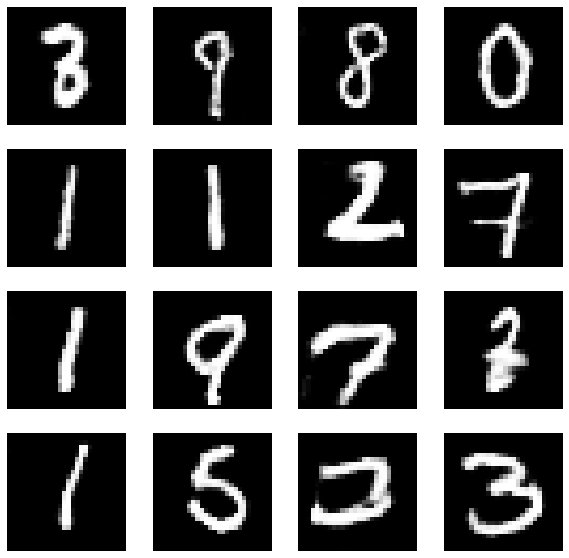

31000: [discriminator loss: 0.6475403308868408, acc: 0.6796875] [gan loss: 1.050588, acc: 0.421875]
31001: [discriminator loss: 0.5095393657684326, acc: 0.7578125] [gan loss: 1.216555, acc: 0.265625]
31002: [discriminator loss: 0.5946601033210754, acc: 0.71875] [gan loss: 1.198647, acc: 0.234375]
31003: [discriminator loss: 0.5175007581710815, acc: 0.71875] [gan loss: 1.314368, acc: 0.250000]
31004: [discriminator loss: 0.5230972766876221, acc: 0.6875] [gan loss: 0.917932, acc: 0.437500]
31005: [discriminator loss: 0.4790738523006439, acc: 0.75] [gan loss: 1.257208, acc: 0.281250]
31006: [discriminator loss: 0.5791574120521545, acc: 0.671875] [gan loss: 1.253693, acc: 0.375000]
31007: [discriminator loss: 0.5683532953262329, acc: 0.6640625] [gan loss: 1.230177, acc: 0.281250]
31008: [discriminator loss: 0.537826657295227, acc: 0.703125] [gan loss: 1.233822, acc: 0.296875]
31009: [discriminator loss: 0.49857449531555176, acc: 0.765625] [gan loss: 1.320101, acc: 0.218750]
31010: [discrim

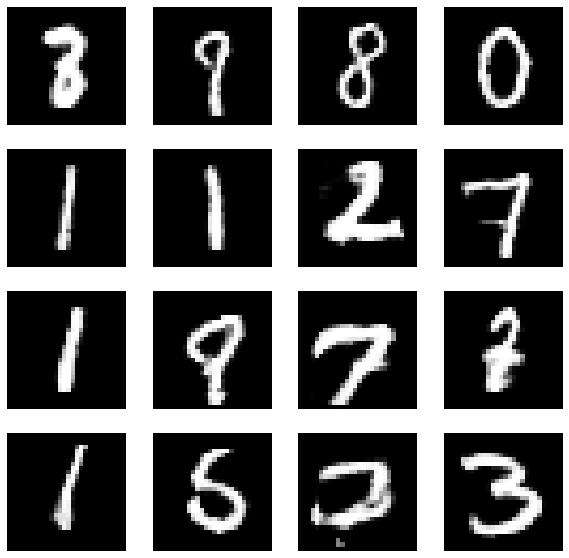

31500: [discriminator loss: 0.5079967975616455, acc: 0.75] [gan loss: 1.319163, acc: 0.203125]
31501: [discriminator loss: 0.6666721105575562, acc: 0.65625] [gan loss: 1.015121, acc: 0.390625]
31502: [discriminator loss: 0.5356547832489014, acc: 0.7421875] [gan loss: 1.489680, acc: 0.187500]
31503: [discriminator loss: 0.501082181930542, acc: 0.75] [gan loss: 1.255424, acc: 0.250000]
31504: [discriminator loss: 0.5200181007385254, acc: 0.734375] [gan loss: 1.675419, acc: 0.109375]
31505: [discriminator loss: 0.5165690183639526, acc: 0.7421875] [gan loss: 1.091688, acc: 0.234375]
31506: [discriminator loss: 0.5189574360847473, acc: 0.7421875] [gan loss: 1.381317, acc: 0.296875]
31507: [discriminator loss: 0.49243631958961487, acc: 0.796875] [gan loss: 1.755698, acc: 0.156250]
31508: [discriminator loss: 0.5720009207725525, acc: 0.6796875] [gan loss: 1.023372, acc: 0.406250]
31509: [discriminator loss: 0.5192881226539612, acc: 0.765625] [gan loss: 1.518474, acc: 0.093750]
31510: [discrim

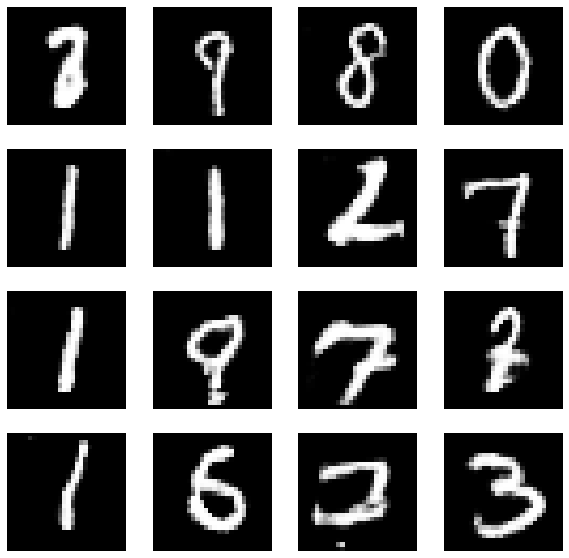

32000: [discriminator loss: 0.4877876043319702, acc: 0.7578125] [gan loss: 1.289283, acc: 0.218750]
32001: [discriminator loss: 0.474243700504303, acc: 0.734375] [gan loss: 1.234177, acc: 0.203125]
32002: [discriminator loss: 0.4393327832221985, acc: 0.8203125] [gan loss: 1.320718, acc: 0.234375]
32003: [discriminator loss: 0.5837094187736511, acc: 0.7109375] [gan loss: 1.584852, acc: 0.093750]
32004: [discriminator loss: 0.5356080532073975, acc: 0.734375] [gan loss: 0.780529, acc: 0.531250]
32005: [discriminator loss: 0.4693046808242798, acc: 0.78125] [gan loss: 1.513198, acc: 0.125000]
32006: [discriminator loss: 0.5716421008110046, acc: 0.671875] [gan loss: 0.831128, acc: 0.531250]
32007: [discriminator loss: 0.5444773435592651, acc: 0.671875] [gan loss: 1.650820, acc: 0.093750]
32008: [discriminator loss: 0.6713335514068604, acc: 0.6171875] [gan loss: 1.050815, acc: 0.375000]
32009: [discriminator loss: 0.5998119115829468, acc: 0.6953125] [gan loss: 1.589982, acc: 0.218750]
32010: 

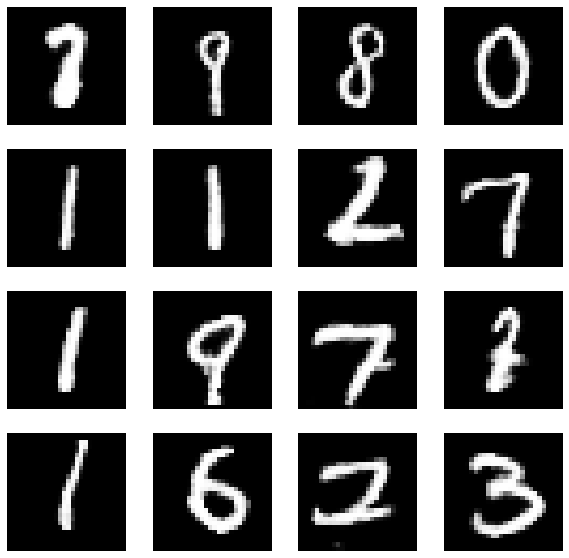

32500: [discriminator loss: 0.5106413960456848, acc: 0.7421875] [gan loss: 1.133292, acc: 0.296875]
32501: [discriminator loss: 0.5403754711151123, acc: 0.75] [gan loss: 1.156088, acc: 0.375000]
32502: [discriminator loss: 0.5486385822296143, acc: 0.734375] [gan loss: 1.220129, acc: 0.312500]
32503: [discriminator loss: 0.5034284591674805, acc: 0.7109375] [gan loss: 0.726774, acc: 0.531250]
32504: [discriminator loss: 0.5314568281173706, acc: 0.765625] [gan loss: 1.245338, acc: 0.234375]
32505: [discriminator loss: 0.5458347797393799, acc: 0.7109375] [gan loss: 1.069664, acc: 0.359375]
32506: [discriminator loss: 0.5402215719223022, acc: 0.7109375] [gan loss: 1.405900, acc: 0.156250]
32507: [discriminator loss: 0.4485785663127899, acc: 0.765625] [gan loss: 0.870348, acc: 0.453125]
32508: [discriminator loss: 0.5374897718429565, acc: 0.7265625] [gan loss: 1.882736, acc: 0.140625]
32509: [discriminator loss: 0.5900707244873047, acc: 0.6796875] [gan loss: 1.190449, acc: 0.328125]
32510: [

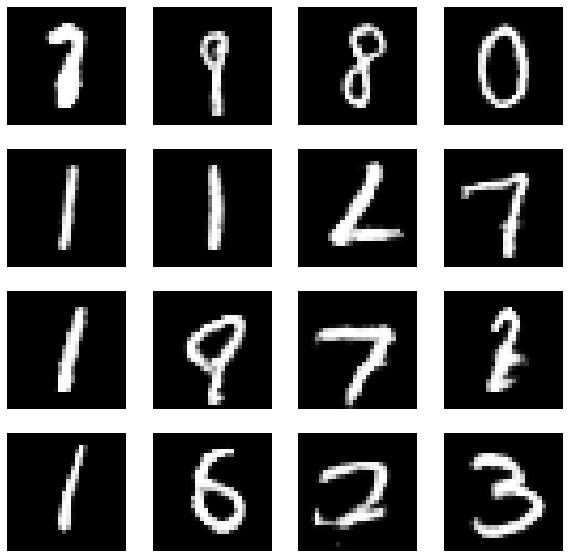

33000: [discriminator loss: 0.5953490138053894, acc: 0.671875] [gan loss: 0.859532, acc: 0.531250]
33001: [discriminator loss: 0.6126881241798401, acc: 0.703125] [gan loss: 1.707321, acc: 0.125000]
33002: [discriminator loss: 0.5815461277961731, acc: 0.6796875] [gan loss: 1.028754, acc: 0.296875]
33003: [discriminator loss: 0.5833494663238525, acc: 0.6875] [gan loss: 1.644617, acc: 0.140625]
33004: [discriminator loss: 0.5120863914489746, acc: 0.7421875] [gan loss: 1.079224, acc: 0.328125]
33005: [discriminator loss: 0.5427830219268799, acc: 0.734375] [gan loss: 1.270199, acc: 0.234375]
33006: [discriminator loss: 0.5233815312385559, acc: 0.71875] [gan loss: 0.947696, acc: 0.500000]
33007: [discriminator loss: 0.5974512696266174, acc: 0.671875] [gan loss: 1.832483, acc: 0.062500]
33008: [discriminator loss: 0.5744050741195679, acc: 0.6640625] [gan loss: 0.791348, acc: 0.562500]
33009: [discriminator loss: 0.5623425245285034, acc: 0.65625] [gan loss: 1.322263, acc: 0.109375]
33010: [dis

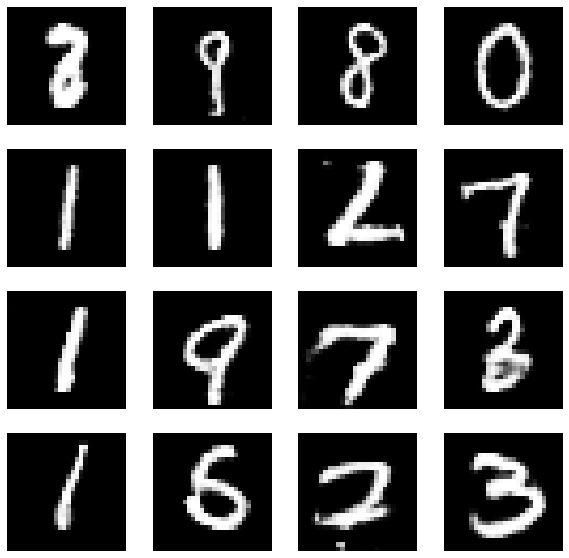

33500: [discriminator loss: 0.5372245907783508, acc: 0.7265625] [gan loss: 1.020014, acc: 0.328125]
33501: [discriminator loss: 0.5708897709846497, acc: 0.6484375] [gan loss: 1.800175, acc: 0.140625]
33502: [discriminator loss: 0.577222466468811, acc: 0.7109375] [gan loss: 0.982223, acc: 0.437500]
33503: [discriminator loss: 0.5365676283836365, acc: 0.7421875] [gan loss: 1.716909, acc: 0.156250]
33504: [discriminator loss: 0.5575968027114868, acc: 0.6875] [gan loss: 0.992555, acc: 0.312500]
33505: [discriminator loss: 0.5149352550506592, acc: 0.7734375] [gan loss: 1.250067, acc: 0.281250]
33506: [discriminator loss: 0.5629757046699524, acc: 0.734375] [gan loss: 1.156330, acc: 0.343750]
33507: [discriminator loss: 0.44863173365592957, acc: 0.8046875] [gan loss: 1.372130, acc: 0.156250]
33508: [discriminator loss: 0.468169629573822, acc: 0.7734375] [gan loss: 0.992665, acc: 0.421875]
33509: [discriminator loss: 0.49950265884399414, acc: 0.796875] [gan loss: 1.199049, acc: 0.203125]
33510

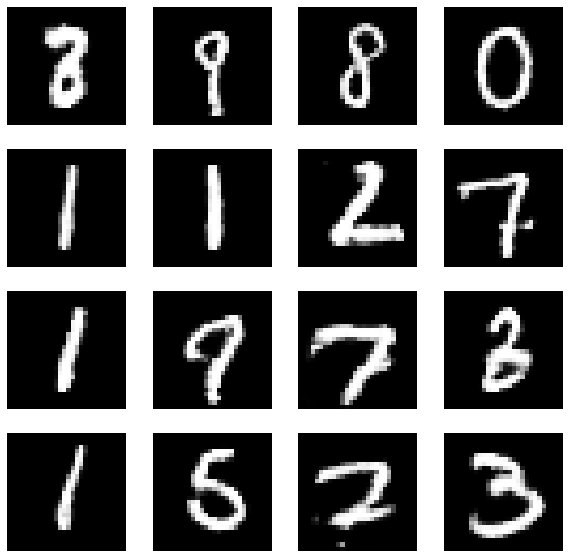

34000: [discriminator loss: 0.4936819076538086, acc: 0.765625] [gan loss: 1.026071, acc: 0.375000]
34001: [discriminator loss: 0.54808509349823, acc: 0.734375] [gan loss: 1.578591, acc: 0.187500]
34002: [discriminator loss: 0.5053344368934631, acc: 0.7421875] [gan loss: 1.151958, acc: 0.250000]
34003: [discriminator loss: 0.5171890258789062, acc: 0.75] [gan loss: 0.928123, acc: 0.390625]
34004: [discriminator loss: 0.5122216939926147, acc: 0.7421875] [gan loss: 2.037252, acc: 0.046875]
34005: [discriminator loss: 0.589004397392273, acc: 0.6875] [gan loss: 0.722955, acc: 0.562500]
34006: [discriminator loss: 0.5253192186355591, acc: 0.75] [gan loss: 1.873046, acc: 0.125000]
34007: [discriminator loss: 0.5877737998962402, acc: 0.6640625] [gan loss: 0.946784, acc: 0.531250]
34008: [discriminator loss: 0.5086541175842285, acc: 0.7734375] [gan loss: 1.286694, acc: 0.234375]
34009: [discriminator loss: 0.5512388944625854, acc: 0.671875] [gan loss: 1.356699, acc: 0.281250]
34010: [discriminat

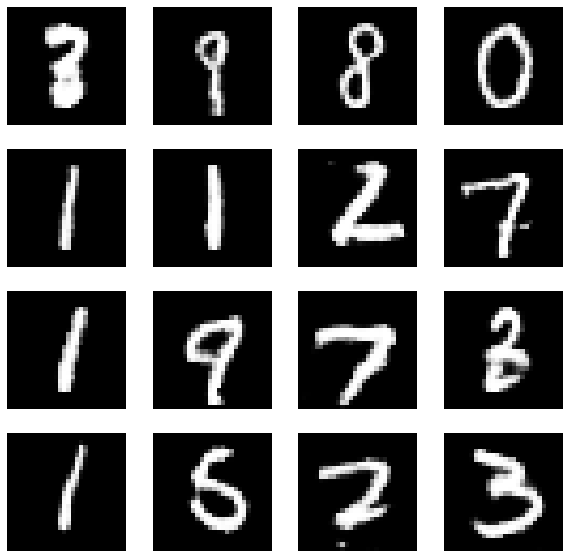

34500: [discriminator loss: 0.5588825941085815, acc: 0.71875] [gan loss: 1.236567, acc: 0.203125]
34501: [discriminator loss: 0.5205034017562866, acc: 0.7265625] [gan loss: 1.155558, acc: 0.250000]
34502: [discriminator loss: 0.5425160527229309, acc: 0.75] [gan loss: 1.391516, acc: 0.171875]
34503: [discriminator loss: 0.48815810680389404, acc: 0.7578125] [gan loss: 1.212821, acc: 0.265625]
34504: [discriminator loss: 0.5137323141098022, acc: 0.7578125] [gan loss: 1.328437, acc: 0.218750]
34505: [discriminator loss: 0.45707786083221436, acc: 0.765625] [gan loss: 1.086728, acc: 0.375000]
34506: [discriminator loss: 0.44178375601768494, acc: 0.7890625] [gan loss: 1.290893, acc: 0.265625]
34507: [discriminator loss: 0.49082258343696594, acc: 0.7421875] [gan loss: 0.885338, acc: 0.500000]
34508: [discriminator loss: 0.5517542362213135, acc: 0.7265625] [gan loss: 1.380067, acc: 0.203125]
34509: [discriminator loss: 0.5069422125816345, acc: 0.765625] [gan loss: 1.041758, acc: 0.312500]
34510

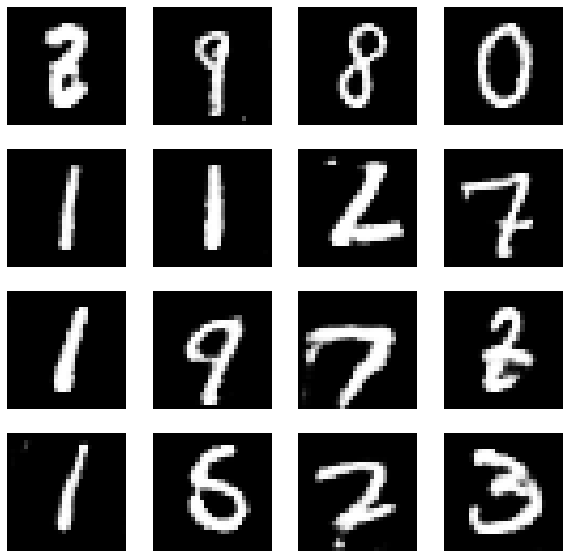

35000: [discriminator loss: 0.497046560049057, acc: 0.78125] [gan loss: 1.490863, acc: 0.125000]
35001: [discriminator loss: 0.5259981155395508, acc: 0.7109375] [gan loss: 0.915755, acc: 0.437500]
35002: [discriminator loss: 0.5848313570022583, acc: 0.7109375] [gan loss: 1.817363, acc: 0.093750]
35003: [discriminator loss: 0.6137272715568542, acc: 0.6796875] [gan loss: 0.835375, acc: 0.531250]
35004: [discriminator loss: 0.7651958465576172, acc: 0.53125] [gan loss: 1.691551, acc: 0.078125]
35005: [discriminator loss: 0.5215103626251221, acc: 0.734375] [gan loss: 1.156200, acc: 0.250000]
35006: [discriminator loss: 0.48929208517074585, acc: 0.7421875] [gan loss: 1.475770, acc: 0.187500]
35007: [discriminator loss: 0.5910725593566895, acc: 0.6875] [gan loss: 1.171913, acc: 0.281250]
35008: [discriminator loss: 0.47479745745658875, acc: 0.8125] [gan loss: 1.511483, acc: 0.078125]
35009: [discriminator loss: 0.4723038673400879, acc: 0.7578125] [gan loss: 1.136013, acc: 0.343750]
35010: [di

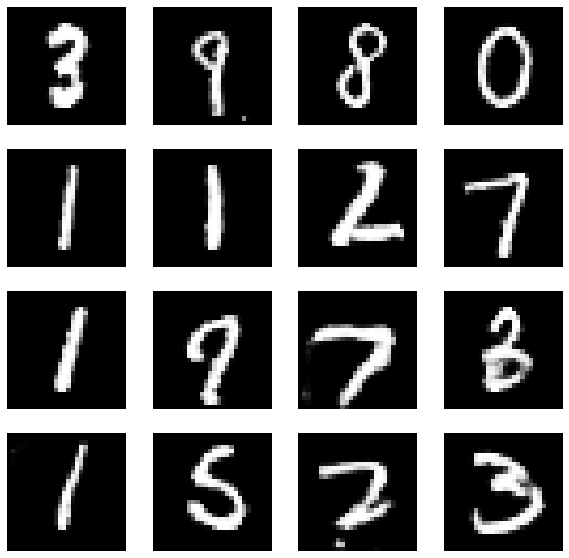

35500: [discriminator loss: 0.4724395275115967, acc: 0.7578125] [gan loss: 1.163063, acc: 0.296875]
35501: [discriminator loss: 0.46001100540161133, acc: 0.765625] [gan loss: 1.474132, acc: 0.156250]
35502: [discriminator loss: 0.5265622138977051, acc: 0.765625] [gan loss: 1.413734, acc: 0.140625]
35503: [discriminator loss: 0.44384169578552246, acc: 0.828125] [gan loss: 1.336858, acc: 0.203125]
35504: [discriminator loss: 0.49194732308387756, acc: 0.71875] [gan loss: 1.072769, acc: 0.390625]
35505: [discriminator loss: 0.4982754588127136, acc: 0.78125] [gan loss: 1.576047, acc: 0.156250]
35506: [discriminator loss: 0.5507323145866394, acc: 0.71875] [gan loss: 1.053826, acc: 0.437500]
35507: [discriminator loss: 0.5690587759017944, acc: 0.6953125] [gan loss: 1.339680, acc: 0.265625]
35508: [discriminator loss: 0.5774832367897034, acc: 0.6875] [gan loss: 0.980981, acc: 0.390625]
35509: [discriminator loss: 0.44760656356811523, acc: 0.78125] [gan loss: 1.562584, acc: 0.140625]
35510: [di

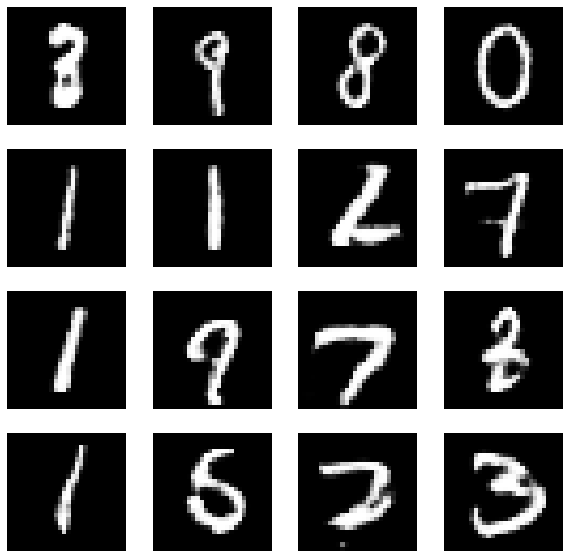

36000: [discriminator loss: 0.565611720085144, acc: 0.6875] [gan loss: 1.017008, acc: 0.343750]
36001: [discriminator loss: 0.5203056335449219, acc: 0.7265625] [gan loss: 1.282687, acc: 0.187500]
36002: [discriminator loss: 0.5737887620925903, acc: 0.671875] [gan loss: 1.303351, acc: 0.234375]
36003: [discriminator loss: 0.5008907318115234, acc: 0.7578125] [gan loss: 1.263876, acc: 0.265625]
36004: [discriminator loss: 0.523966908454895, acc: 0.734375] [gan loss: 1.297285, acc: 0.250000]
36005: [discriminator loss: 0.4915582537651062, acc: 0.7421875] [gan loss: 1.392812, acc: 0.187500]
36006: [discriminator loss: 0.5240777134895325, acc: 0.7109375] [gan loss: 1.147539, acc: 0.421875]
36007: [discriminator loss: 0.529129683971405, acc: 0.71875] [gan loss: 1.503593, acc: 0.156250]
36008: [discriminator loss: 0.5593675374984741, acc: 0.703125] [gan loss: 1.049108, acc: 0.406250]
36009: [discriminator loss: 0.43438780307769775, acc: 0.8359375] [gan loss: 1.044990, acc: 0.265625]
36010: [di

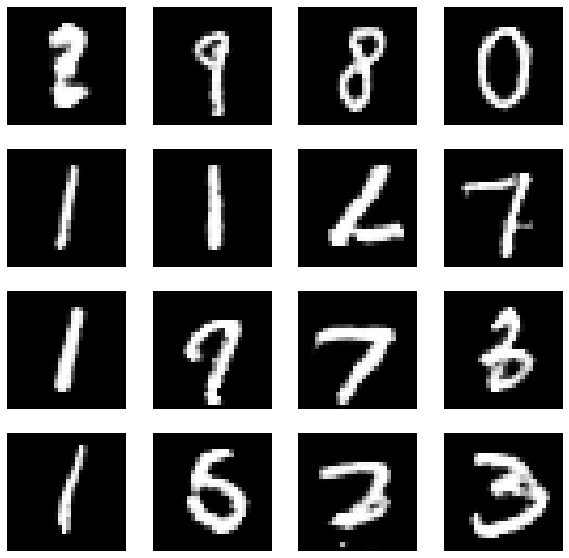

36500: [discriminator loss: 0.5172640085220337, acc: 0.7578125] [gan loss: 1.475760, acc: 0.156250]
36501: [discriminator loss: 0.5184468030929565, acc: 0.7578125] [gan loss: 1.292953, acc: 0.296875]
36502: [discriminator loss: 0.5217134952545166, acc: 0.734375] [gan loss: 1.493665, acc: 0.171875]
36503: [discriminator loss: 0.5609145164489746, acc: 0.6875] [gan loss: 1.206344, acc: 0.218750]
36504: [discriminator loss: 0.4828212261199951, acc: 0.796875] [gan loss: 1.186071, acc: 0.343750]
36505: [discriminator loss: 0.4664413630962372, acc: 0.796875] [gan loss: 1.185232, acc: 0.328125]
36506: [discriminator loss: 0.5248687863349915, acc: 0.71875] [gan loss: 1.738621, acc: 0.140625]
36507: [discriminator loss: 0.6058284640312195, acc: 0.65625] [gan loss: 0.755968, acc: 0.562500]
36508: [discriminator loss: 0.5951778888702393, acc: 0.703125] [gan loss: 1.472827, acc: 0.171875]
36509: [discriminator loss: 0.6188071966171265, acc: 0.59375] [gan loss: 1.001143, acc: 0.328125]
36510: [discr

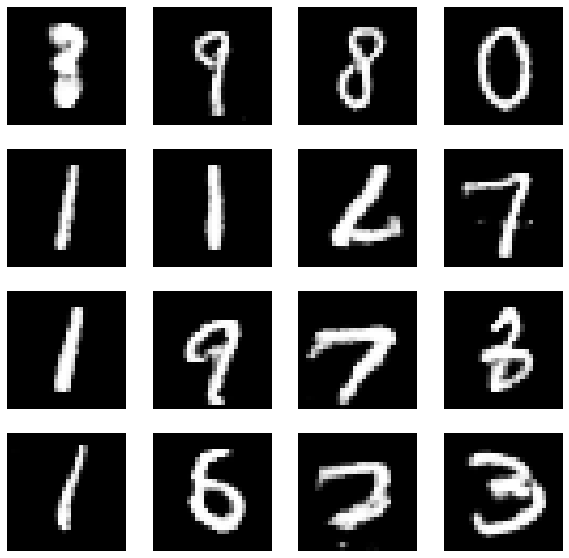

37000: [discriminator loss: 0.44518011808395386, acc: 0.7890625] [gan loss: 1.109000, acc: 0.250000]
37001: [discriminator loss: 0.5255720615386963, acc: 0.7265625] [gan loss: 1.146447, acc: 0.343750]
37002: [discriminator loss: 0.513891875743866, acc: 0.7578125] [gan loss: 1.162476, acc: 0.312500]
37003: [discriminator loss: 0.6075867414474487, acc: 0.734375] [gan loss: 1.574354, acc: 0.156250]
37004: [discriminator loss: 0.5206882357597351, acc: 0.765625] [gan loss: 0.945708, acc: 0.437500]
37005: [discriminator loss: 0.5502228736877441, acc: 0.7109375] [gan loss: 1.353790, acc: 0.203125]
37006: [discriminator loss: 0.5067318081855774, acc: 0.7578125] [gan loss: 1.195710, acc: 0.312500]
37007: [discriminator loss: 0.5167661905288696, acc: 0.75] [gan loss: 1.214939, acc: 0.265625]
37008: [discriminator loss: 0.4744126796722412, acc: 0.7734375] [gan loss: 1.120493, acc: 0.375000]
37009: [discriminator loss: 0.5279889106750488, acc: 0.7421875] [gan loss: 1.550434, acc: 0.140625]
37010: 

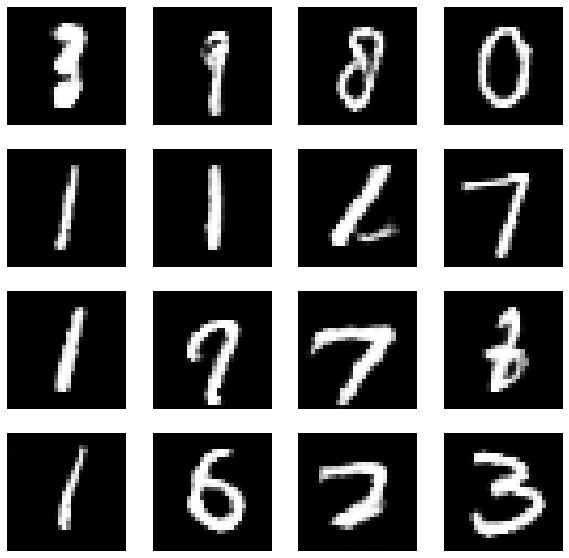

37500: [discriminator loss: 0.5271968841552734, acc: 0.7265625] [gan loss: 1.362705, acc: 0.234375]
37501: [discriminator loss: 0.5098505020141602, acc: 0.734375] [gan loss: 1.081190, acc: 0.375000]
37502: [discriminator loss: 0.4786750376224518, acc: 0.7890625] [gan loss: 1.342773, acc: 0.203125]
37503: [discriminator loss: 0.5787419676780701, acc: 0.640625] [gan loss: 1.228213, acc: 0.234375]
37504: [discriminator loss: 0.4621511697769165, acc: 0.8203125] [gan loss: 1.073579, acc: 0.250000]
37505: [discriminator loss: 0.47058194875717163, acc: 0.7890625] [gan loss: 1.342888, acc: 0.234375]
37506: [discriminator loss: 0.43866443634033203, acc: 0.7734375] [gan loss: 1.258671, acc: 0.312500]
37507: [discriminator loss: 0.5327367782592773, acc: 0.71875] [gan loss: 1.558623, acc: 0.234375]
37508: [discriminator loss: 0.5576444268226624, acc: 0.7109375] [gan loss: 0.665985, acc: 0.687500]
37509: [discriminator loss: 0.5579466819763184, acc: 0.671875] [gan loss: 1.445826, acc: 0.125000]
375

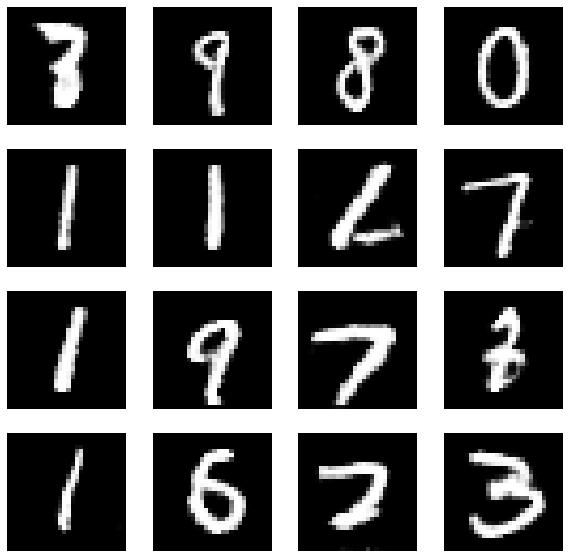

38000: [discriminator loss: 0.455075740814209, acc: 0.7734375] [gan loss: 1.211650, acc: 0.234375]
38001: [discriminator loss: 0.481988787651062, acc: 0.796875] [gan loss: 1.287959, acc: 0.171875]
38002: [discriminator loss: 0.5571247339248657, acc: 0.703125] [gan loss: 1.822791, acc: 0.125000]
38003: [discriminator loss: 0.5025234818458557, acc: 0.7421875] [gan loss: 1.183691, acc: 0.343750]
38004: [discriminator loss: 0.5139765739440918, acc: 0.71875] [gan loss: 1.441185, acc: 0.187500]
38005: [discriminator loss: 0.5460922718048096, acc: 0.71875] [gan loss: 1.022197, acc: 0.390625]
38006: [discriminator loss: 0.4825366735458374, acc: 0.765625] [gan loss: 1.637192, acc: 0.218750]
38007: [discriminator loss: 0.5077435970306396, acc: 0.765625] [gan loss: 1.206997, acc: 0.265625]
38008: [discriminator loss: 0.5417606830596924, acc: 0.7109375] [gan loss: 1.362402, acc: 0.171875]
38009: [discriminator loss: 0.5061417818069458, acc: 0.7265625] [gan loss: 1.367292, acc: 0.250000]
38010: [di

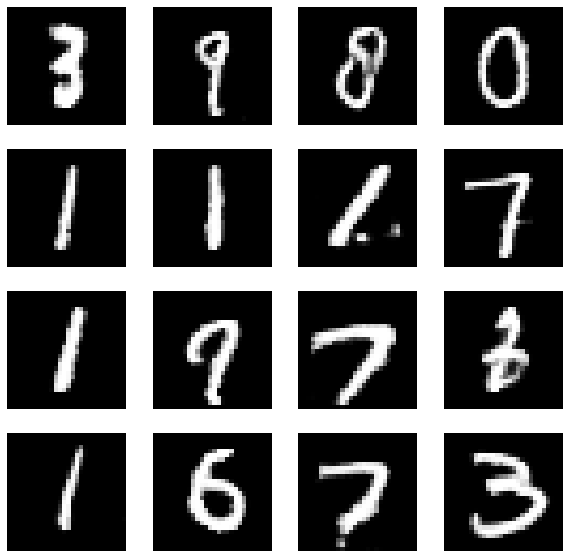

38500: [discriminator loss: 0.657931923866272, acc: 0.640625] [gan loss: 1.037769, acc: 0.390625]
38501: [discriminator loss: 0.5107152462005615, acc: 0.7265625] [gan loss: 1.694378, acc: 0.093750]
38502: [discriminator loss: 0.5017060041427612, acc: 0.7265625] [gan loss: 1.009475, acc: 0.375000]
38503: [discriminator loss: 0.5116355419158936, acc: 0.7265625] [gan loss: 1.517283, acc: 0.171875]
38504: [discriminator loss: 0.6381739974021912, acc: 0.6640625] [gan loss: 1.041129, acc: 0.421875]
38505: [discriminator loss: 0.4902738928794861, acc: 0.7734375] [gan loss: 1.299979, acc: 0.250000]
38506: [discriminator loss: 0.5153059959411621, acc: 0.75] [gan loss: 1.543918, acc: 0.109375]
38507: [discriminator loss: 0.5292983055114746, acc: 0.7265625] [gan loss: 1.079364, acc: 0.359375]
38508: [discriminator loss: 0.5614255666732788, acc: 0.6875] [gan loss: 1.668522, acc: 0.109375]
38509: [discriminator loss: 0.5467513799667358, acc: 0.71875] [gan loss: 0.788492, acc: 0.500000]
38510: [disc

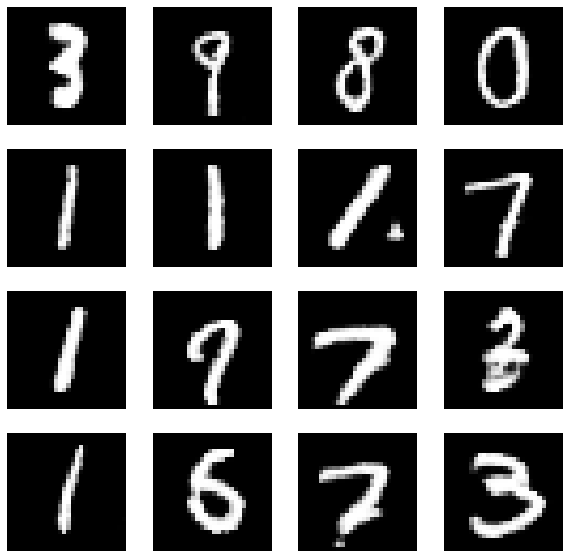

39000: [discriminator loss: 0.5560553073883057, acc: 0.703125] [gan loss: 1.043187, acc: 0.343750]
39001: [discriminator loss: 0.5753581523895264, acc: 0.6640625] [gan loss: 1.858596, acc: 0.109375]
39002: [discriminator loss: 0.5311344861984253, acc: 0.71875] [gan loss: 1.086822, acc: 0.328125]
39003: [discriminator loss: 0.47283029556274414, acc: 0.7734375] [gan loss: 1.721930, acc: 0.093750]
39004: [discriminator loss: 0.5099636316299438, acc: 0.734375] [gan loss: 1.265946, acc: 0.312500]
39005: [discriminator loss: 0.5716807842254639, acc: 0.6796875] [gan loss: 1.631938, acc: 0.109375]
39006: [discriminator loss: 0.559471070766449, acc: 0.7265625] [gan loss: 1.194082, acc: 0.296875]
39007: [discriminator loss: 0.5432907938957214, acc: 0.6953125] [gan loss: 1.221755, acc: 0.312500]
39008: [discriminator loss: 0.5670632719993591, acc: 0.703125] [gan loss: 1.308684, acc: 0.234375]
39009: [discriminator loss: 0.5035985708236694, acc: 0.75] [gan loss: 1.368134, acc: 0.218750]
39010: [di

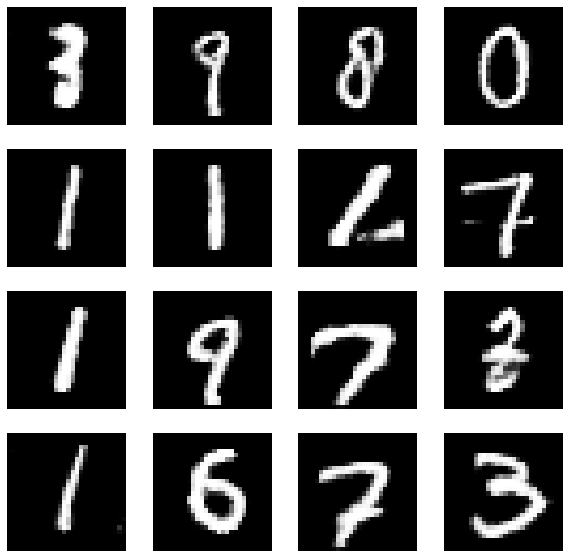

39500: [discriminator loss: 0.5779424905776978, acc: 0.6953125] [gan loss: 1.422911, acc: 0.218750]
39501: [discriminator loss: 0.6135542988777161, acc: 0.6640625] [gan loss: 1.019462, acc: 0.406250]
39502: [discriminator loss: 0.5594009160995483, acc: 0.734375] [gan loss: 1.527502, acc: 0.109375]
39503: [discriminator loss: 0.49347129464149475, acc: 0.7421875] [gan loss: 0.913753, acc: 0.468750]
39504: [discriminator loss: 0.5007197260856628, acc: 0.7421875] [gan loss: 1.333268, acc: 0.187500]
39505: [discriminator loss: 0.5802410840988159, acc: 0.6875] [gan loss: 1.142667, acc: 0.390625]
39506: [discriminator loss: 0.44374334812164307, acc: 0.78125] [gan loss: 1.311462, acc: 0.312500]
39507: [discriminator loss: 0.46450209617614746, acc: 0.8125] [gan loss: 1.376814, acc: 0.203125]
39508: [discriminator loss: 0.5543005466461182, acc: 0.7109375] [gan loss: 1.067640, acc: 0.406250]
39509: [discriminator loss: 0.433952271938324, acc: 0.8046875] [gan loss: 1.604844, acc: 0.140625]
39510: 

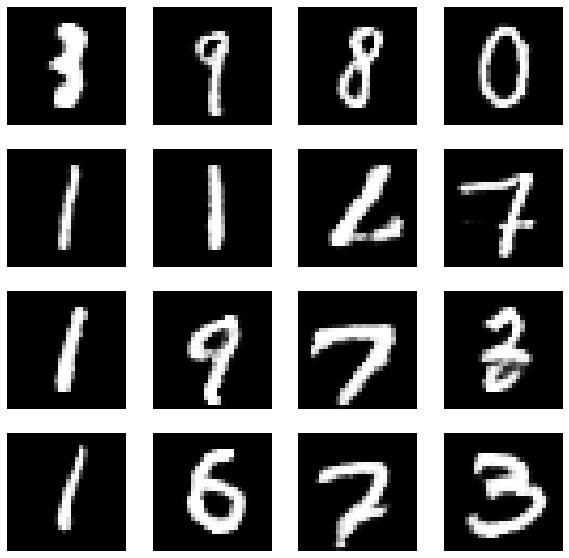

In [ ]:
build_model(x_train)

In [ ]:
noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
plt.plot(noise_input[0])
noise_input.shape


In [ ]:
np.ones([2 * 64, 1])